In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
from scipy.interpolate import interp1d

from jupyter_server import serverapp as app; 
import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

In [6]:
import analysis.mathematical_functions.funcs as funcs

In [7]:
data_folder = project_path+'/data/parameter_runs/many_kappas/'
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [8]:
data_files

['../data/parameter_runs/many_kappas//01-10-19--04-06-2023abm_result_feather']

In [9]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [10]:
datadf['first_tb'].unique()

array([29.47310585, 20.68064554,         inf, ..., 10.84717367,
        5.99631146,  3.10555556])

In [11]:
R0s = np.array(sorted(list(set(datadf['infection_rate']))))
mu_s = np.array(sorted(list(set(datadf['mutation_rate']))))
xi_s = np.array(sorted(list(set(datadf['xi']))))
kappa_s = np.array(sorted(list(set(datadf['kappa']))))
N = datadf['N'].unique()[0]

In [12]:
%load_ext autoreload

In [13]:
cwd = os.getcwd()
folder_name = cwd.split('/')[-1]

parallel_subfolder= 'results/parameter_runs/'+ folder_name
results_folder = os.path.relpath(project_path+'/'+parallel_subfolder)
os.makedirs(results_folder,exist_ok=True)

In [18]:
data_files[0][funcs.find_end_substring(data_files[0],parallel_subfolder)+1: data_files[0].find('abm')]

'ppas//01-10-19--04-06-2023'

In [25]:
results_name

'../results/parameter_runs/Figure4/01-10-19--04-06-2023abm_result_feather'

In [24]:
if len(data_files)==1:
    dataname = data_files[0][data_files[0].find('//')+2:]
    results_name = results_folder+'/'+dataname
else:
    raise ValueError

In [16]:
filtered_df = datadf[~datadf.isin([np.inf, -np.inf]).any(axis=1)]

In [26]:
def get_p_evo_from_df(R0,mu,xi, datadf):
    dpdf = datadf.query(f'infection_rate =={R0} & mutation_rate=={mu} & xi=={xi}')
    return 1-len(dpdf[datadf.isin([np.inf, -np.inf]).any(axis=1)])/len(dpdf)

if not os.path.exists(results_name+'p_evo_df.feather'):
    p_evo_df = pd.DataFrame.from_dict({i:(mu,xi,r ,get_p_evo_from_df(r,mu,xi,datadf)) for i,(mu,xi,r) in enumerate(funcs.product(mu_s,xi_s,R0s))},orient='index', columns=['mu','xi','R0','p_evo'])
    p_evo_df.to_feather(results_name+'p_evo_df.feather')
else:
    p_evo_df = pd.read_feather(results_name+'p_evo_df.feather')
    

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
filtered_df['muN'] =np.round(filtered_df['mutation_rate']*filtered_df['N'])
p_evo_df['N']=N
p_evo_df['muN'] =np.round(p_evo_df['mu']*p_evo_df['N'],0)
filtered_df['first_d_over_xi']=filtered_df['first_d']/filtered_df['xi']




/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
p_alpha = datadf['p_alpha'].unique()[0]
xi_d = -1/np.log(1-p_alpha)

In [29]:
filtered_df['$R_0$'] = filtered_df['infection_rate']
filtered_df['$\mu N$'] = np.round(filtered_df['muN'],0)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
exp_number_mutants = lambda R0, kappa, xi, p_alpha: (1-funcs.x_inf(R0,kappa))**2/(2 + 2*(p_alpha*xi))
filtered_df['exp_number_mutants'] = filtered_df.apply(lambda row: exp_number_mutants(row['infection_rate'],row['kappa'],row['xi'],p_alpha), axis=1)


/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.05, 'antigenic effect of first crosser')

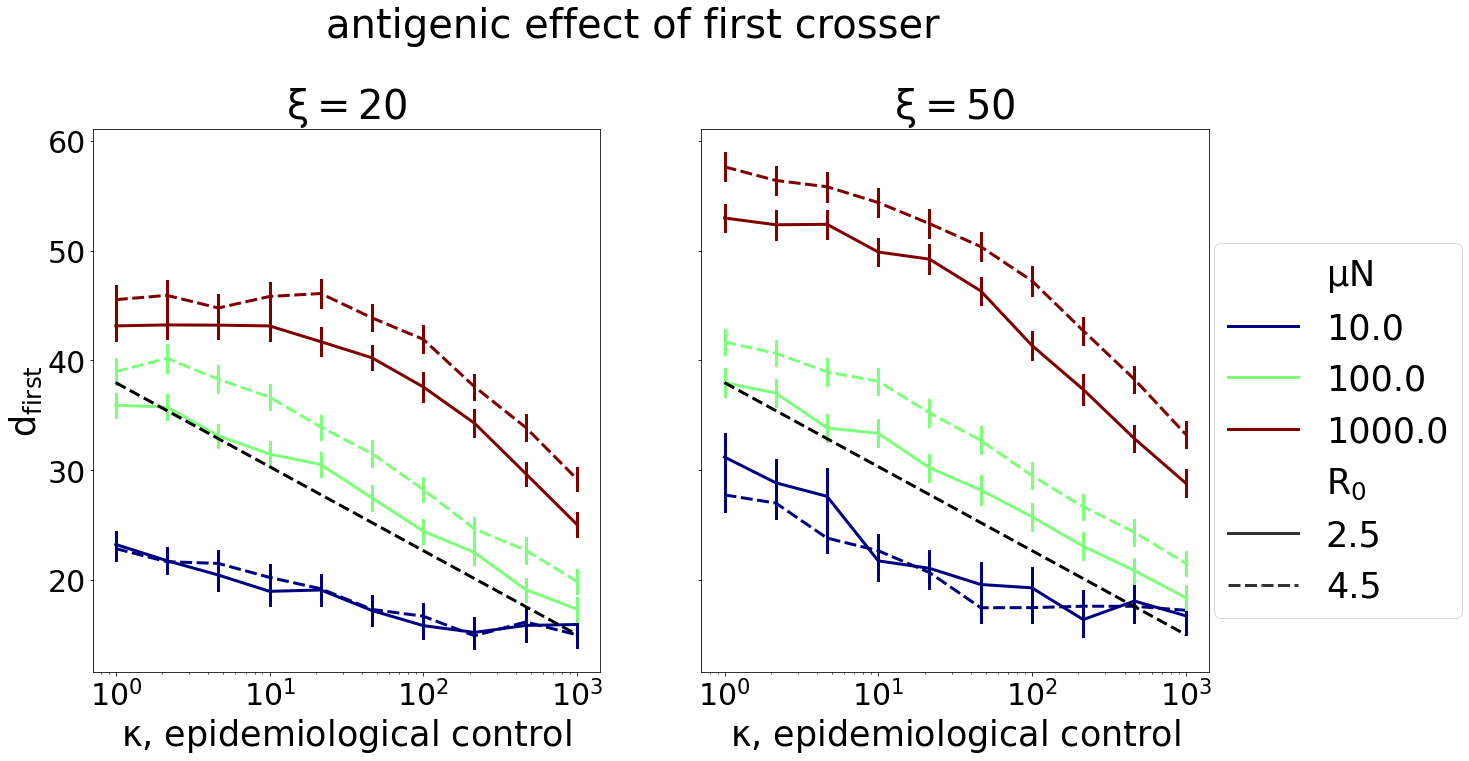

In [31]:
fig,ax =plt.subplots(1,len(xi_s), figsize=(len(xi_s)*10,10),sharey=True)
for ix,xi in enumerate(xi_s):
    
    zeta = xi_d/xi
    if ix == len(xi_s)-1:
        legend = 'auto'
    else:
        legend=  None
    sns.lineplot(data =filtered_df[filtered_df['xi']==xi],x= 'kappa',y='first_d', hue='$\mu N$', style='$R_0$', ax= ax[ix],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
    # sns.lineplot(data =solutions_df[solutions_df['xi']==xi],x='R0',y='d_opt', hue='muN', ax= ax[0],palette=plt.cm.jet,legend=None, hue_norm=mpl.colors.LogNorm(),linestyle=':')
    ax[ix].set_title(fr'$\xi={xi:.0f}$', fontsize=40)
    # for mu in mu_s:
    #     ax[ix].plot(kappa_s, xi_d* np.log(mu*N*(1-1/R0*(1-R0/kappa_s))))# color=color_mus[mu], linestyle='--')
    # ax[1].legend(title=r'$\mu N$, mutation rate',loc=(1.01,.1),title_fontsize=40)
    ax[ix].plot(kappa_s, xi_d* (4-.35*np.log(kappa_s)), color='black', linestyle='--')
    # for R0 in R0s:
        # ax[ix].plot(kappa_s, xi_d* (np.log(mu*N*(R0-1)/kappa_s)), color='black', linestyle='--')
for a in ax:
    a.set_xscale('log')
    
    a.set_xlabel(r'$\kappa$, epidemiological control')

    a.set_ylabel(r'$d_{\mathrm{first}}$')
    
    # a.set_ylim(10,40)
ax[-1].legend(title=r'',loc=(1.01,.1),title_fontsize=40)
fig.suptitle(r'antigenic effect of first crosser', fontsize=40, y=1.05)
# fig.savefig(results_name+'first_d_vs_kappa_comparison_all_mutants.pdf')

Text(0.5, 1.05, 'antigenic effect of first crosser')

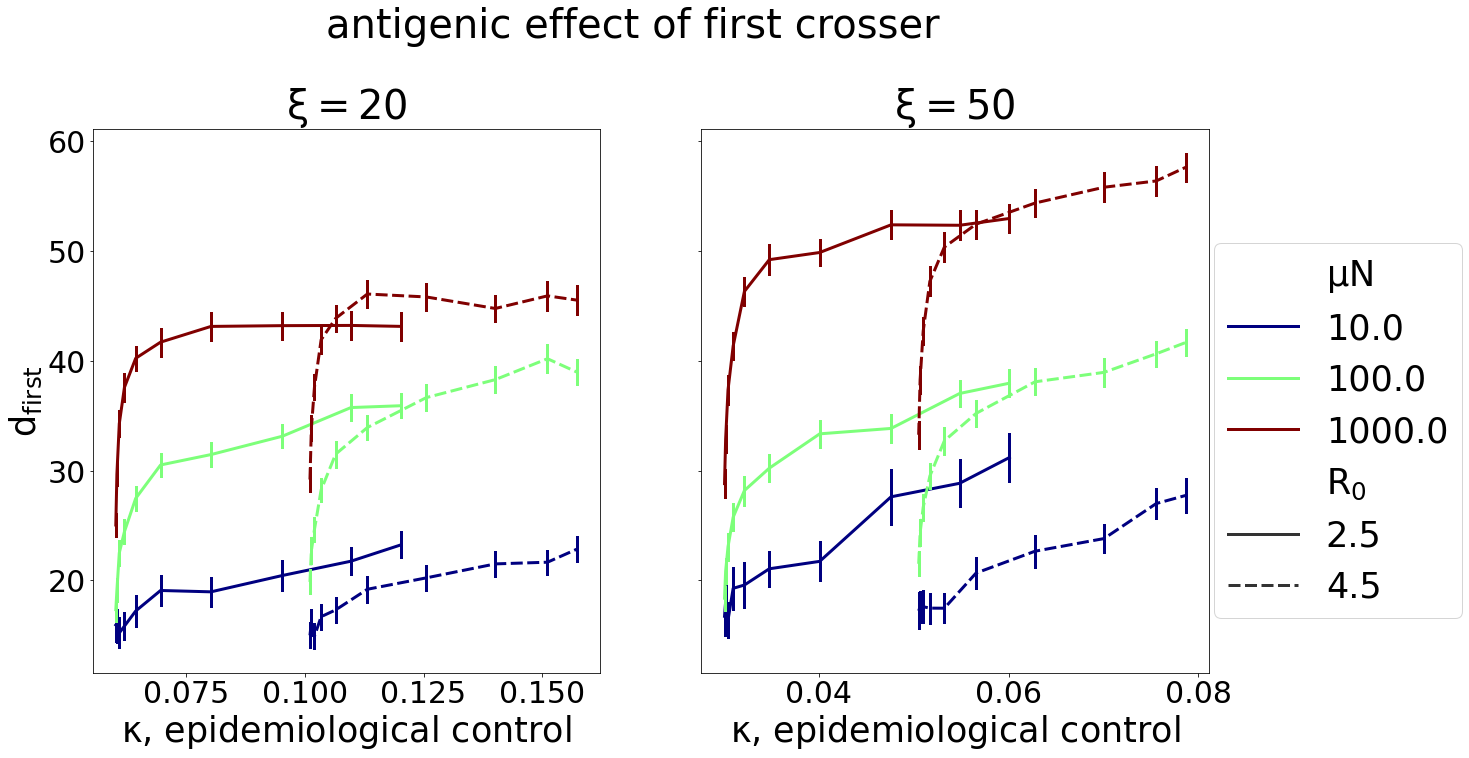

In [21]:
fig,ax =plt.subplots(1,len(xi_s), figsize=(len(xi_s)*10,10),sharey=True)
for ix,xi in enumerate(xi_s):
    
    zeta = xi_d/xi
    if ix == len(xi_s)-1:
        legend = 'auto'
    else:
        legend=  None
    sns.lineplot(data =filtered_df[filtered_df['xi']==xi],x= 'exp_number_mutants',y='first_d', hue='$\mu N$', style='$R_0$', ax= ax[ix],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
    # sns.lineplot(data =solutions_df[solutions_df['xi']==xi],x='R0',y='d_opt', hue='muN', ax= ax[0],palette=plt.cm.jet,legend=None, hue_norm=mpl.colors.LogNorm(),linestyle=':')
    ax[ix].set_title(fr'$\xi={xi:.0f}$', fontsize=40)
    # for mu in mu_s:
    #     ax[ix].plot(kappa_s, xi_d* np.log(mu*N*(1-1/R0*(1-R0/kappa_s))))# color=color_mus[mu], linestyle='--')
    # ax[1].legend(title=r'$\mu N$, mutation rate',loc=(1.01,.1),title_fontsize=40)
    # ax[ix].plot(kappa_s, xi_d* (4-.35*np.log(kappa_s)), color='black', linestyle='--')
    # for R0 in R0s:
        # ax[ix].plot(kappa_s, xi_d* (np.log(mu*N*(R0-1)/kappa_s)), color='black', linestyle='--')
for a in ax:
    # a.set_xscale('log')
    
    a.set_xlabel(r'$\kappa$, epidemiological control')

    a.set_ylabel(r'$d_{\mathrm{first}}$')
    
    # a.set_ylim(10,40)
ax[-1].legend(title=r'',loc=(1.01,.1),title_fontsize=40)
fig.suptitle(r'antigenic effect of first crosser', fontsize=40, y=1.05)

In [22]:
filtered_df['t_first_times_mu'] = filtered_df['first_tb']*filtered_df['mutation_rate']

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
p_alpha*np.log(N) ,xi_d/xi*4

(1.842068074395237, 0.7592977264823924)

Text(0.5, 0.95, 'effects of control')

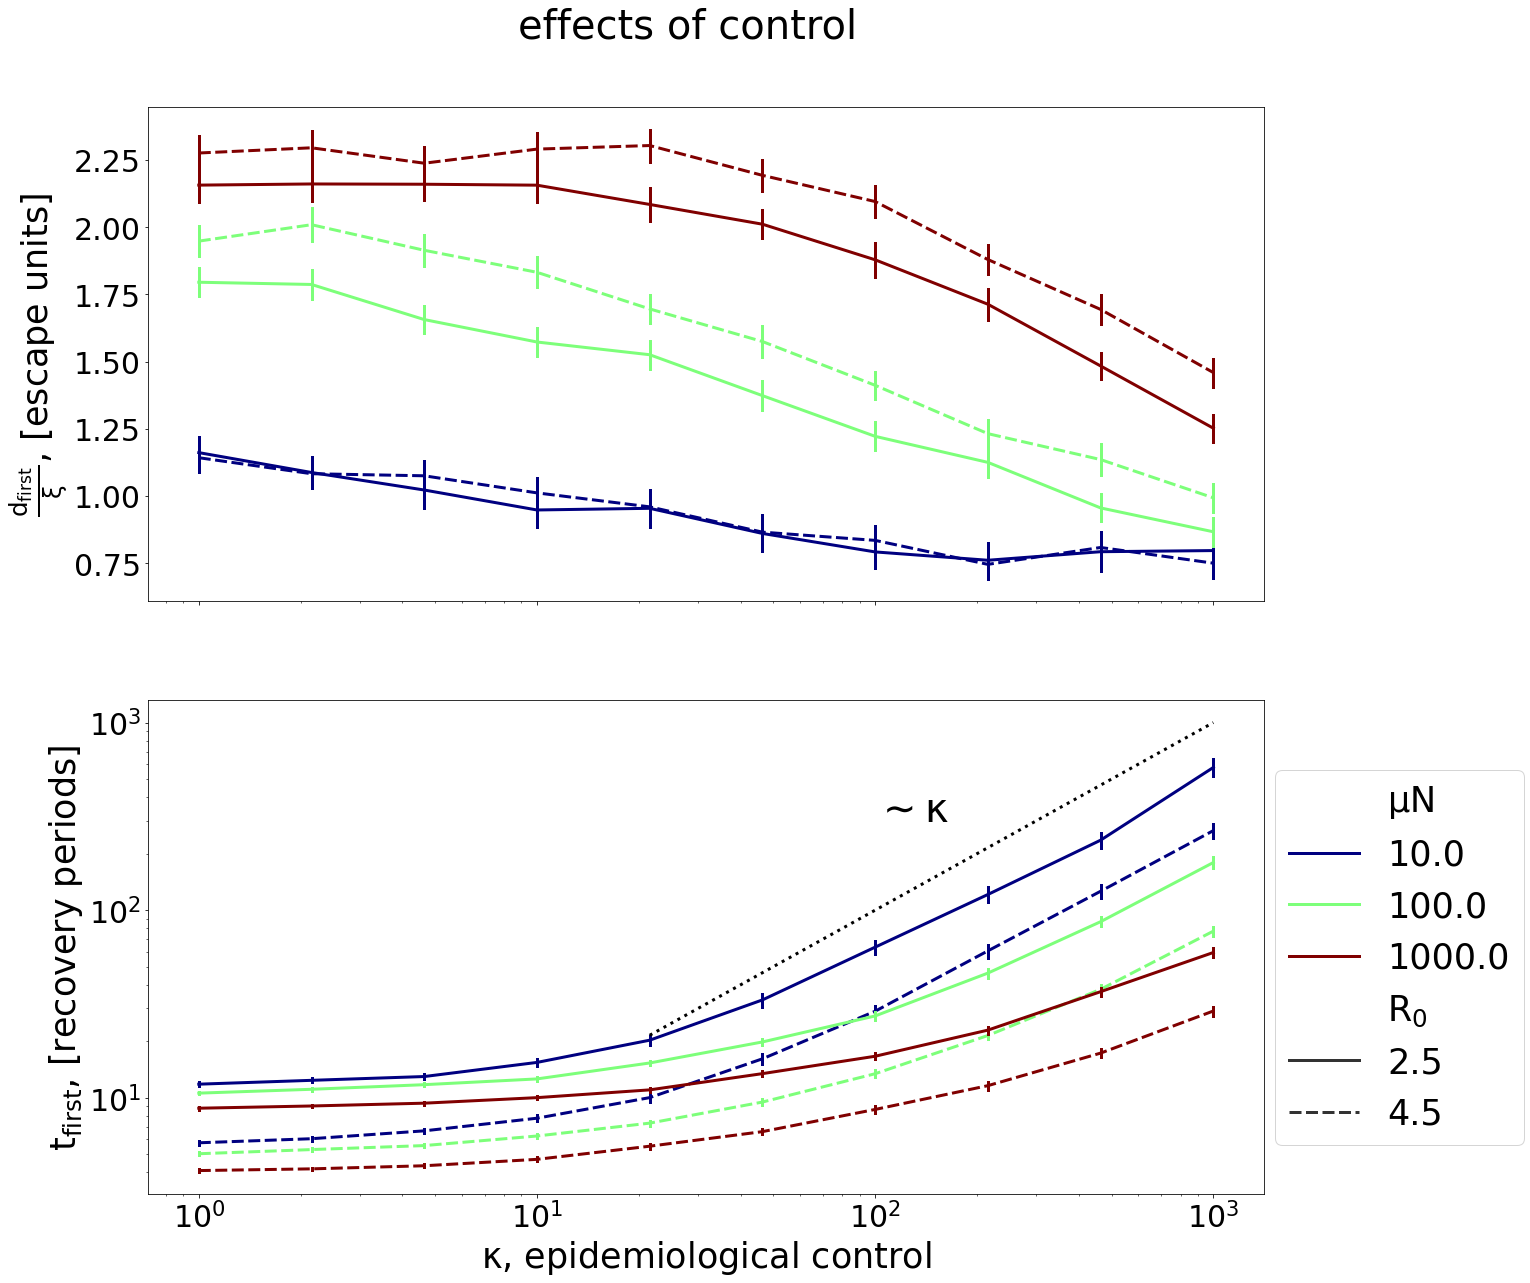

In [34]:
xi  = xi_s[0]
color_mus = funcs.color_dict(mu_s, plt.cm.jet)
fig,ax =plt.subplots(2,1, figsize=(20,20),sharex=True)
## plot first d
legend=  None
sns.lineplot(data =filtered_df[filtered_df['xi']==xi],x= 'kappa',y='first_d_over_xi', hue='$\mu N$', style='$R_0$', ax= ax[0],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
ax[0].set_ylabel(r'$\frac{d_{\mathrm{first}}}{\xi}$, [escape units]')
## plot first_tb
legend = 'auto'
sns.lineplot(data =filtered_df[filtered_df['xi']==xi],x= 'kappa',y='first_tb', hue='$\mu N$', style='$R_0$', ax= ax[1],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
ax[1].set_ylabel(r'$t_{\mathrm{first}}$, [recovery periods]')
ax[1].set_yscale('log')
ax[1].annotate(r'$\sim \kappa$',(1e2,3e2),fontsize=40)
ax[0].annotate(r'$\sim -\log\kappa$',(1e2,2.5),fontsize=40)

ax[1].plot(kappa_s[kappa_s>20], kappa_s[kappa_s>20], color='k', linestyle=':')

# ax[1].plot(kappa_s[kappa_s>20], np.sqrt(kappa_s[kappa_s>20]), color='k', linestyle=':')
# ax[0].plot(kappa_s, xi_d/xi* (4-.35*np.log(kappa_s)), color='black', linestyle=':')
# ax[0].plot(kappa_s, 1/(p_alpha*xi)*np.log(mu*N* np.sqrt(R0/kappa_s * (1-1/R0*(1-R0/kappa_s)))), color='black', linestyle=':')
#ax[ix].set_title(fr'$\xi={xi:.0f}$', fontsize=40)

# for mu in mu_s:
#     #(\[Kappa]*Log(((1 - (1 - R0/\[Kappa])/R0)*\[Mu]N)/(-1 + (1 - (1 - R0/\[Kappa])/R0)*\[Mu]N)))/R0
#     ax[1].plot(kappa_s[kappa_s>=100], kappa_s[kappa_s>=100]/R0 * np.log(mu*N*(1-1/R0*(1-R0/kappa_s[kappa_s>=100]))/(-1+mu*N*(1-1/R0*(1-R0/kappa_s[kappa_s>=100])))), color=color_mus[mu], linestyle=':')
for a in ax:
    a.set_xscale('log')
    
    a.set_xlabel(r'$\kappa$, epidemiological control')

    
    
    # a.set_ylim(10,40)
ax[-1].legend(title=r'',loc=(1.01,.1),title_fontsize=40)
fig.suptitle(r'effects of control', fontsize=40, y=.95)
# fig.savefig(results_name+'fig3.pdf', dpi=300, bbox_inches='tight')

Text(0.5, 0.98, 'effects of control')

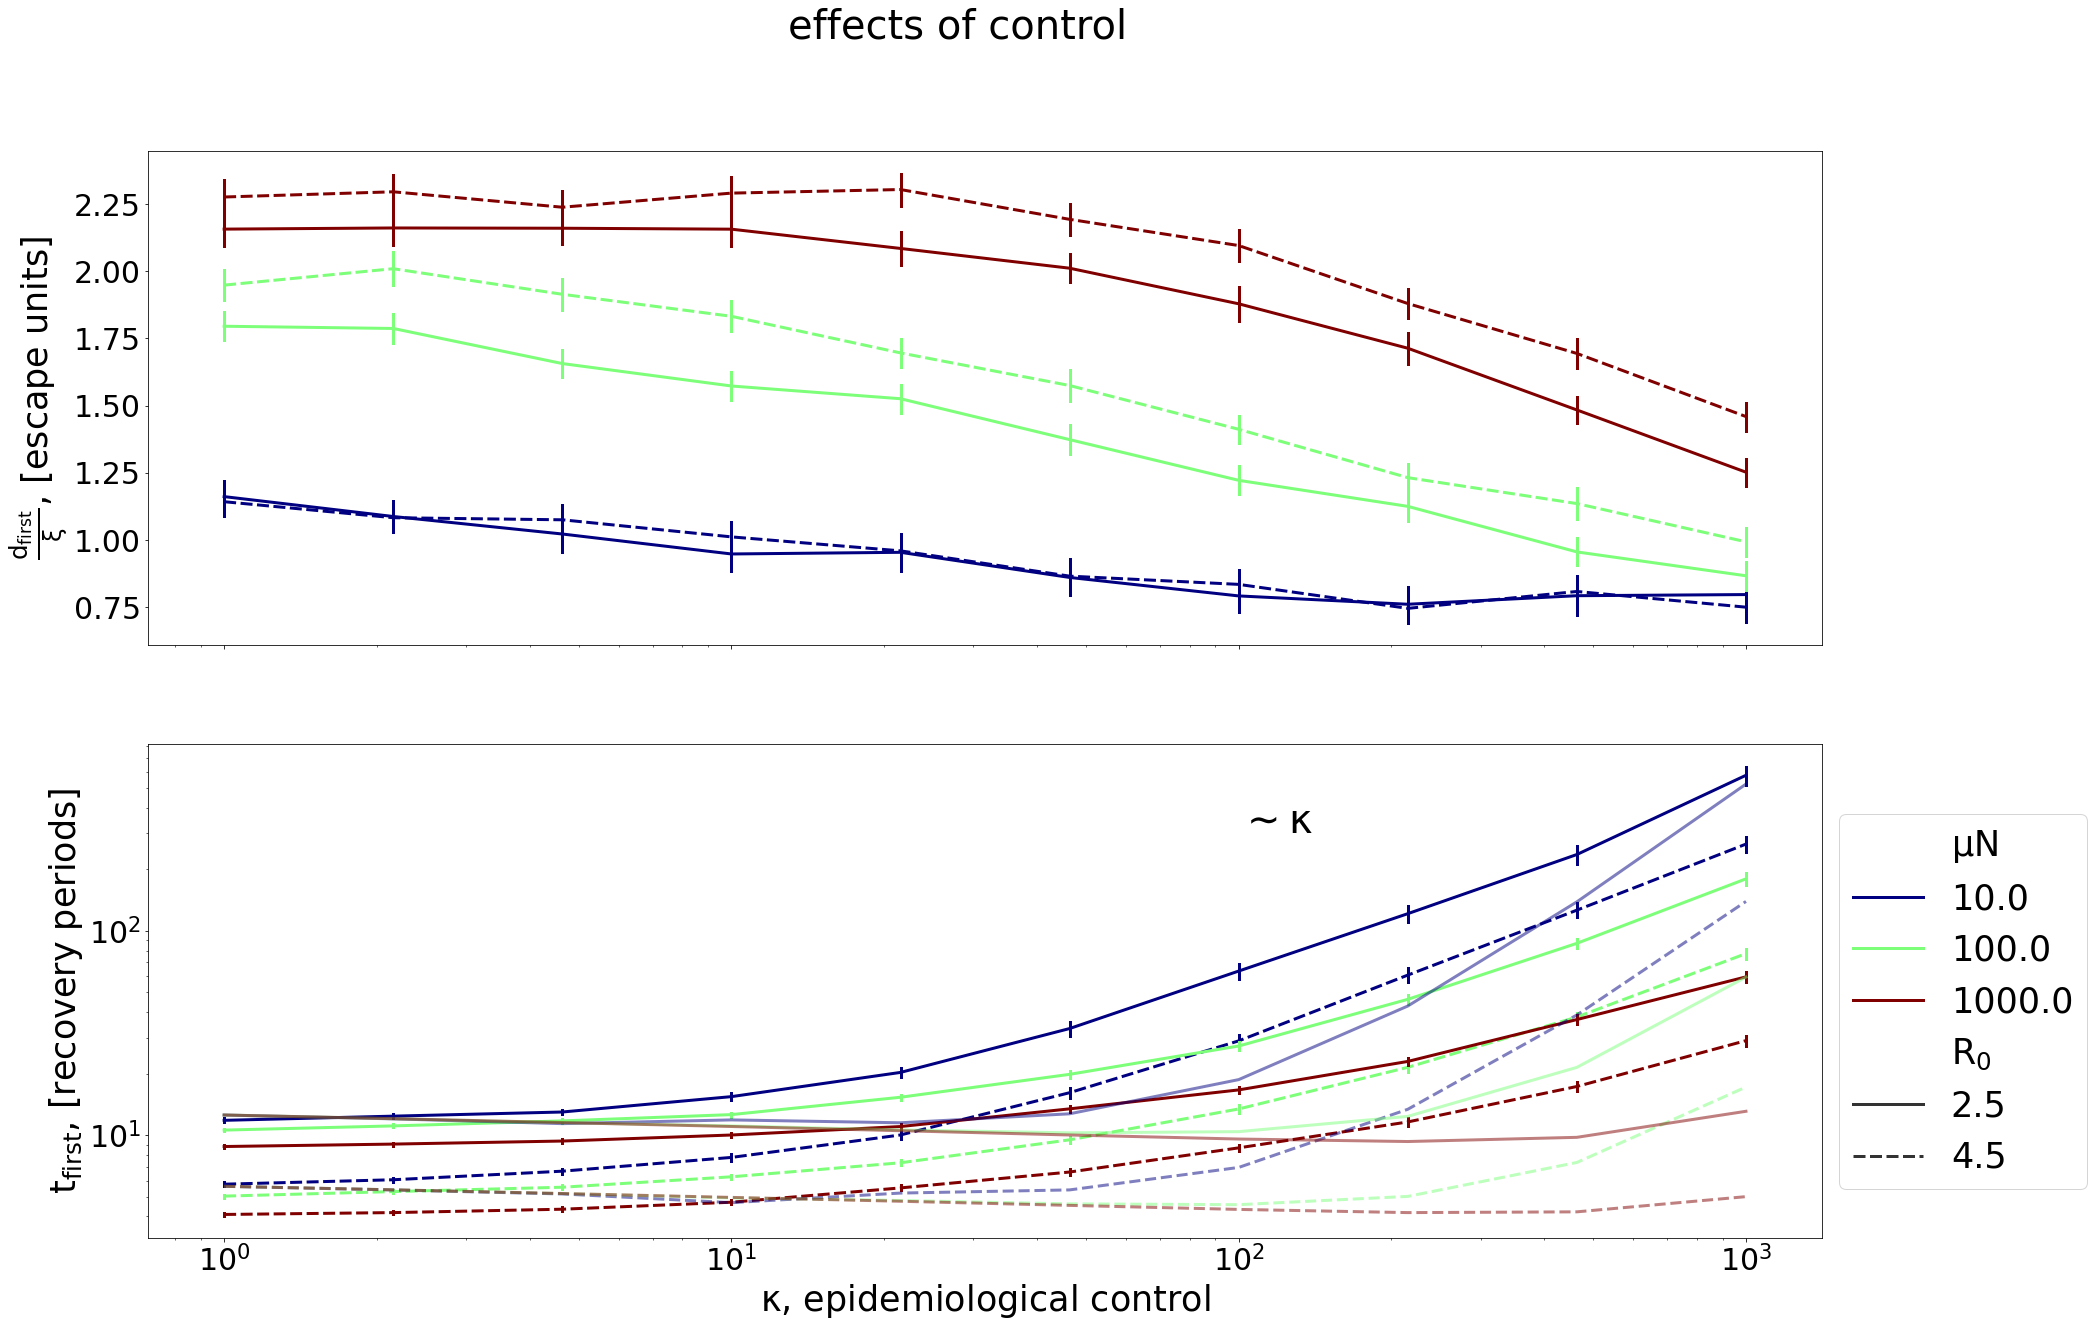

In [26]:
xi  = xi_s[0]
fig,ax =plt.subplots(2,1, figsize=(30,20),sharex=True)
## plot first d
legend=  None
sns.lineplot(data =filtered_df[filtered_df['xi']==xi],x= 'kappa',y='first_d_over_xi', hue='$\mu N$', style='$R_0$', ax= ax[0],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
ax[0].set_ylabel(r'$\frac{d_{\mathrm{first}}}{\xi}$, [escape units]')
## plot first_tb
legend = 'auto'
sns.lineplot(data =filtered_df[filtered_df['xi']==xi],x= 'kappa',y='first_tb', hue='$\mu N$', style='$R_0$', ax= ax[1],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
ax[1].set_ylabel(r'$t_{\mathrm{first}}$, [recovery periods]')
ax[1].set_yscale('log')
ax[1].annotate(r'$\sim \kappa$',(1e2,3e2),fontsize=40)

for mu, R0 in funcs.product(mu_s, R0s):
    z_p = R0/kappa_s * np.log((R0-1)/R0**2 *kappa_s) - (R0-1)/kappa_s
    y_p = (R0-1)/kappa_s
    t_p = np.log(N*y_p)/(R0-1)
    tot_rate= mu*N*y_p*z_p/(1-z_p)*1/(p_alpha*xi)*(2/p_alpha +1 )
    ls = '-' if R0==2.5 else '--'
    ax[1].plot(kappa_s, t_p+ 1/tot_rate, color=color_mus[mu], linestyle=ls,alpha=.5)

for a in ax:
    a.set_xscale('log')
    
    a.set_xlabel(r'$\kappa$, epidemiological control')

    
    
    # a.set_ylim(10,40)
ax[-1].legend(title=r'',loc=(1.01,.1),title_fontsize=40)
fig.suptitle(r'effects of control', fontsize=40)
# fig.savefig(results_name+'effects_of_control.png', dpi=300, bbox_inches='tight')

In [27]:
t_p+ 1/tot_rate

array([5.62095432, 5.40161558, 5.18213946, 4.96020795, 4.74844959,
       4.53323866, 4.33168361, 4.17890883, 4.21517217, 5.00239973])

In [28]:
kappa_s

array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ])

In [29]:
#ignore warnings 
import warnings
warnings.filterwarnings("ignore")

(0.001, 4.393271416544705)

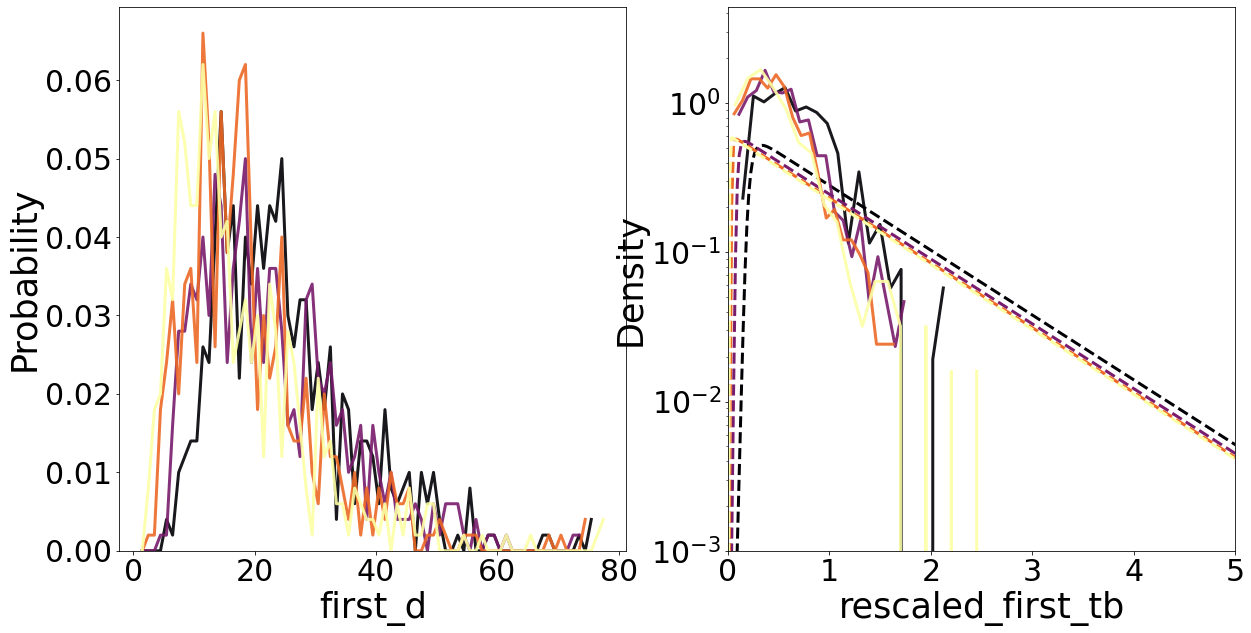

In [30]:
R0 = R0s[0]
kappa = 100
mu = mu_s[1]

xi = xi_s[0]
colors_kappa = funcs.color_dict(kappa_s[kappa_s>=100], plt.cm.inferno)
filtered_df['rescaled_first_tb']= filtered_df['first_tb']*filtered_df['infection_rate']/filtered_df['kappa']
fig,ax= plt.subplots(1,2, figsize=(20,10))
for kappa in kappa_s[kappa_s>=100]:

    T = funcs.T_ext_deterministic(R0,kappa,N)
    ts_det = np.linspace(0,T,1000)
    dt = ts_det[1]-ts_det[0]
    x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T

    qstring = f'xi=={xi} and infection_rate=={R0} and kappa=={kappa} and mutation_rate=={mu}'
    qfiltered=  filtered_df.query(qstring)
    bins = np.arange(1,qfiltered['first_d'].max()+1)

    sns.histplot(data=qfiltered, x='first_d', color= colors_kappa[kappa], ax=ax[0], legend='auto', bins=bins,alpha=.9, stat= 'probability',element='poly',fill=False, label=fr'$\kappa={kappa}$')
    sns.histplot(data=qfiltered, x='rescaled_first_tb', color= colors_kappa[kappa], ax=ax[1], legend='auto', bins=20,alpha=.9, stat= 'density',element='poly',fill=False, label=fr'$\kappa={kappa}$')

    ax[1].plot(ts_det*R0/kappa, y *kappa/R0, color=colors_kappa[kappa], linestyle='--', label='deterministic')
ax[1].set_xlim(0,5)
ax[1].set_yscale('log')

ax[1].set_ylim(bottom=1e-3)

In [31]:
filtered_df.columns

Index(['RunId', 'iteration', 'Step', 'N', 'infection_rate', 'kappa', 'p_alpha',
       'mutation_rate', 'xi', 'recovery_rate', 'initial_infected', 'dt',
       'collect_freqs', 'first_tb', 'first_d', 't_x', 'chi_0', 'muN',
       'first_d_over_xi', '$R_0$', '$\mu N$', 'exp_number_mutants',
       't_first_times_mu', 'rescaled_first_tb'],
      dtype='object')

In [35]:
def get_z_intersection(zfunc, d,tb, R0, N, xi, kappa):
    #to solve: -Log(-1 + (N*(-1 + R0*(1 - z)))/\[Kappa]) - (\[Kappa]*(1 - c(d))*((-1 + R0)*Log((-1 + R0*(1 - zx(d,z)))/(-1 + R0*(1 - z))) + R0*Log((1 - z)/(1 - zx(d,z)))))/R0
    s_d_z= lambda z,d : (1-np.exp(-d/xi))*z/(1-z)
    to_solve = lambda zx, z,d : - np.log(-1 + (N*s_d_z(z,d)  *(-1 + R0*(1 - z)))/kappa) - (kappa*(1 - np.exp(-d/xi))*((-1 + R0)*np.log((-1 + R0*(1 - zx))/(-1 + R0*(1 - z))) + R0*np.log((1 - z)/(1 - zx))))/R0

    zstart =zfunc(tb)
    zx= spo.fsolve(to_solve, .5, args=(zstart, d))
    return zx[0]


def add_z_columns_frequency_intersection(df, R0s, kappa_s, mu_s, xi_s, N):
    qdfs_list = []
    
    for x in funcs.product(R0s,kappa_s,mu_s,xi_s):
        R0,kappa,mu,xi = x
        qstring = f'xi=={xi} and infection_rate=={R0} and kappa=={kappa} and mutation_rate=={mu}'    
        ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
        dt = ts_det[1]-ts_det[0]
        x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
        z_func = interp1d(ts_det,z)


        #update the dataframe at infection rate R0 and kappa 
        qdf = df.query(qstring)
        qdf['z_intersection_predicted'] = qdf.apply(lambda row: get_z_intersection(z_func, row['first_d'], row['first_tb'], R0, N, xi, kappa), axis=1)
        qdf['z_intersection'] = qdf.apply(lambda row: z_func(row['t_x']), axis=1)
        qdf['z_b'] = qdf.apply(lambda row: z_func(row['first_tb']), axis=1)
        qdfs_list.append(qdf)


    print(len(qdfs_list))
    return qdfs_list 

In [36]:
funcs.product(R0s,)

In [37]:
qdfs_list = add_z_columns_frequency_intersection(filtered_df, R0s, kappa_s, mu_s, xi_s, N)
z_df = pd.concat(qdfs_list, ignore_index=True)


/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

120


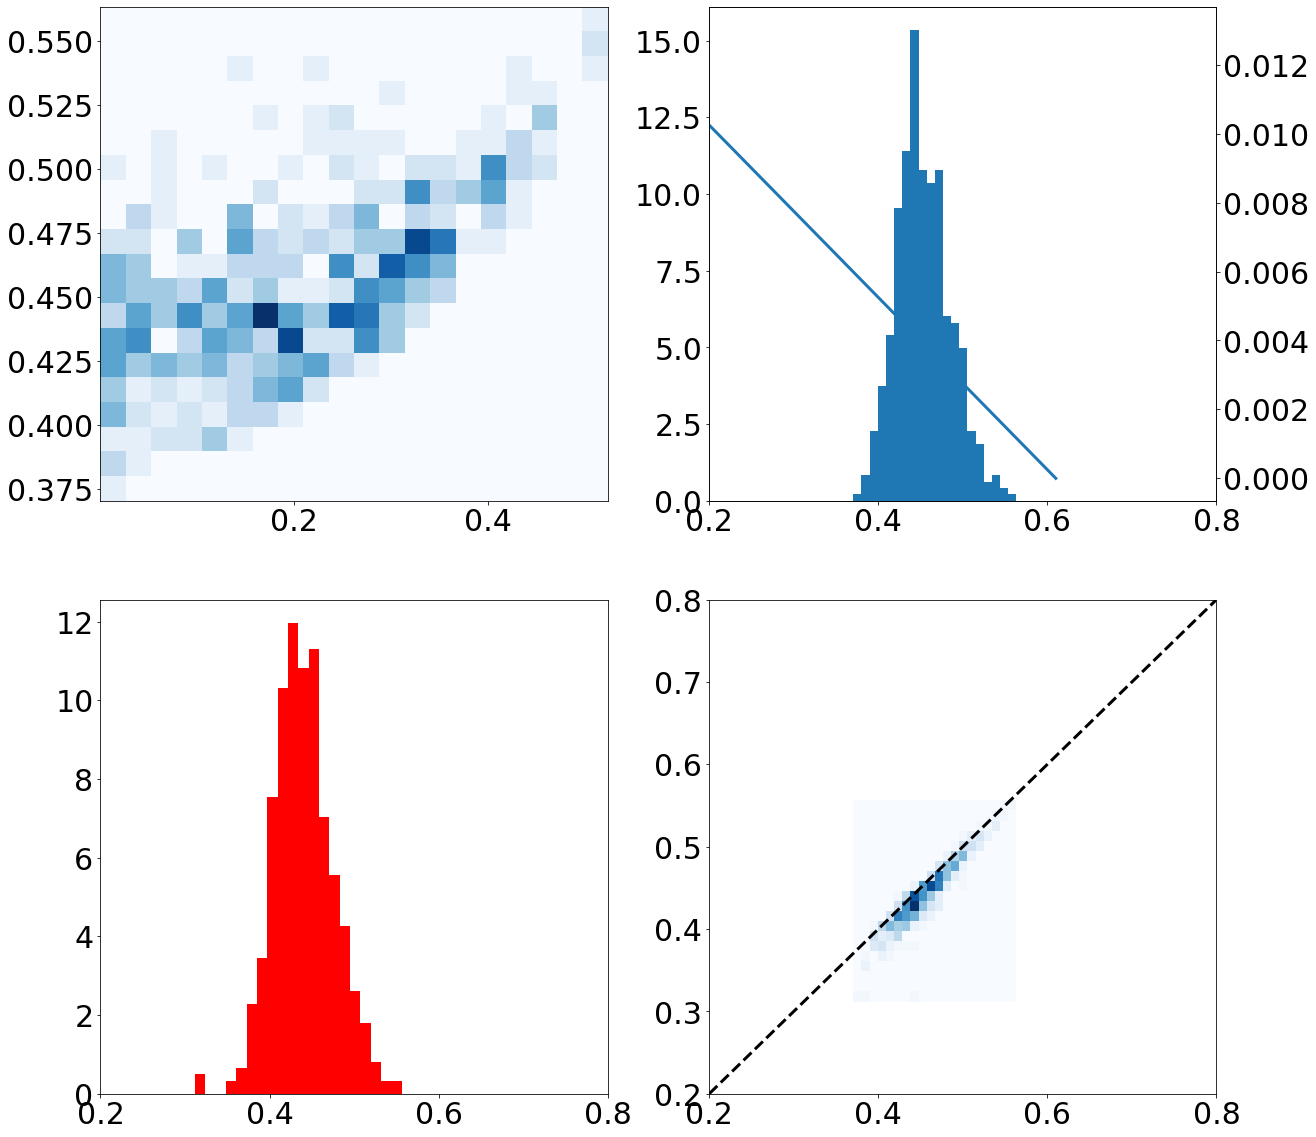

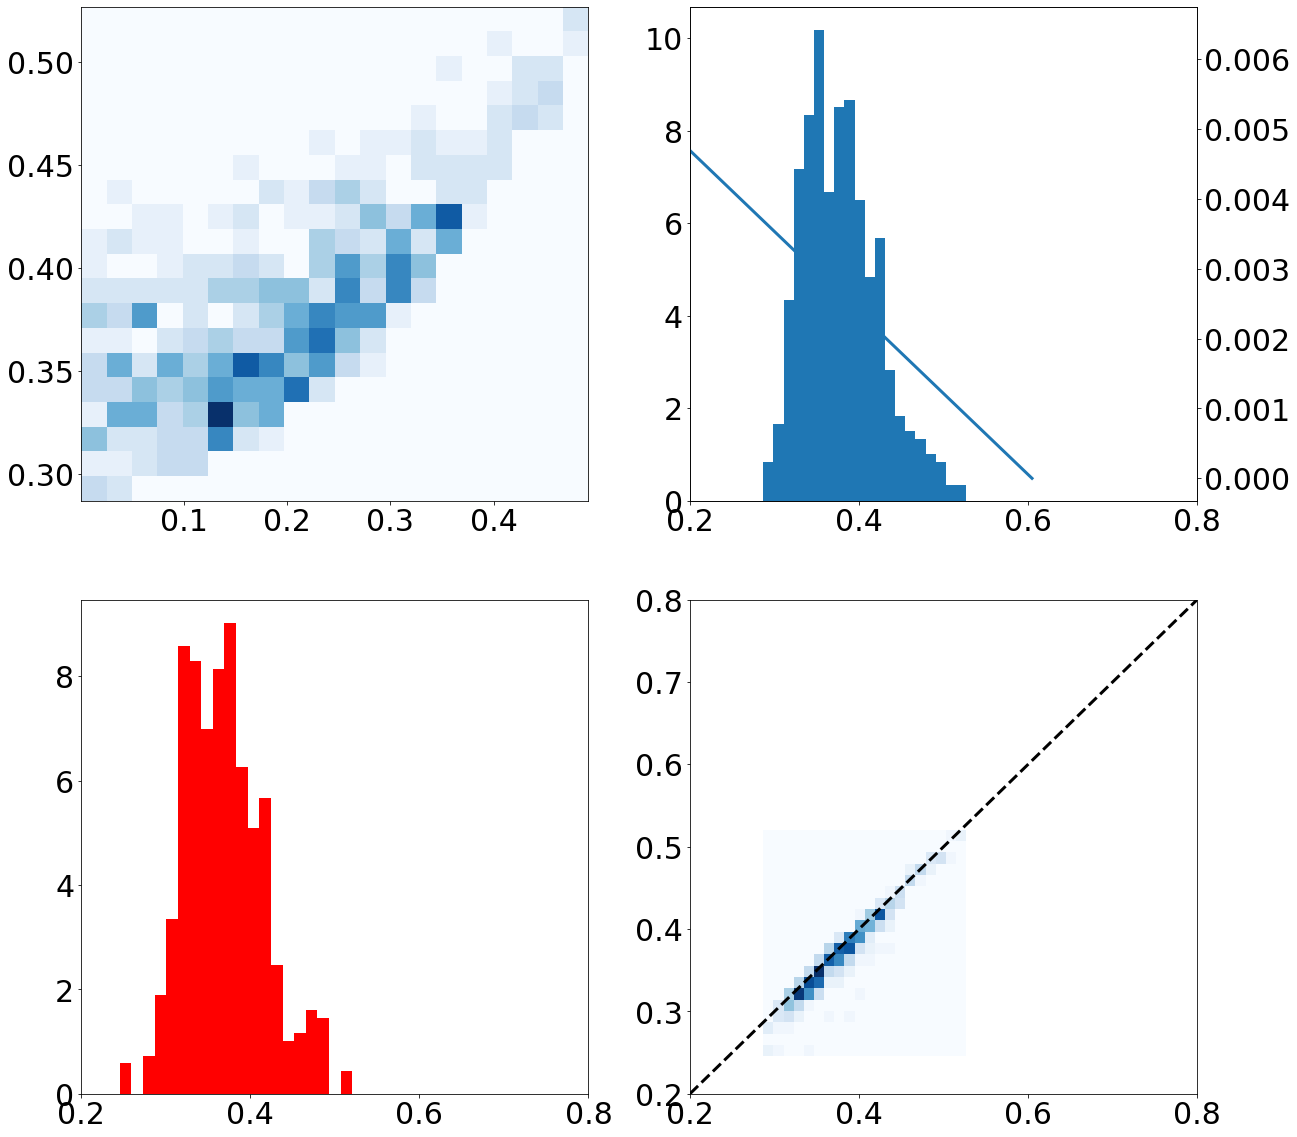

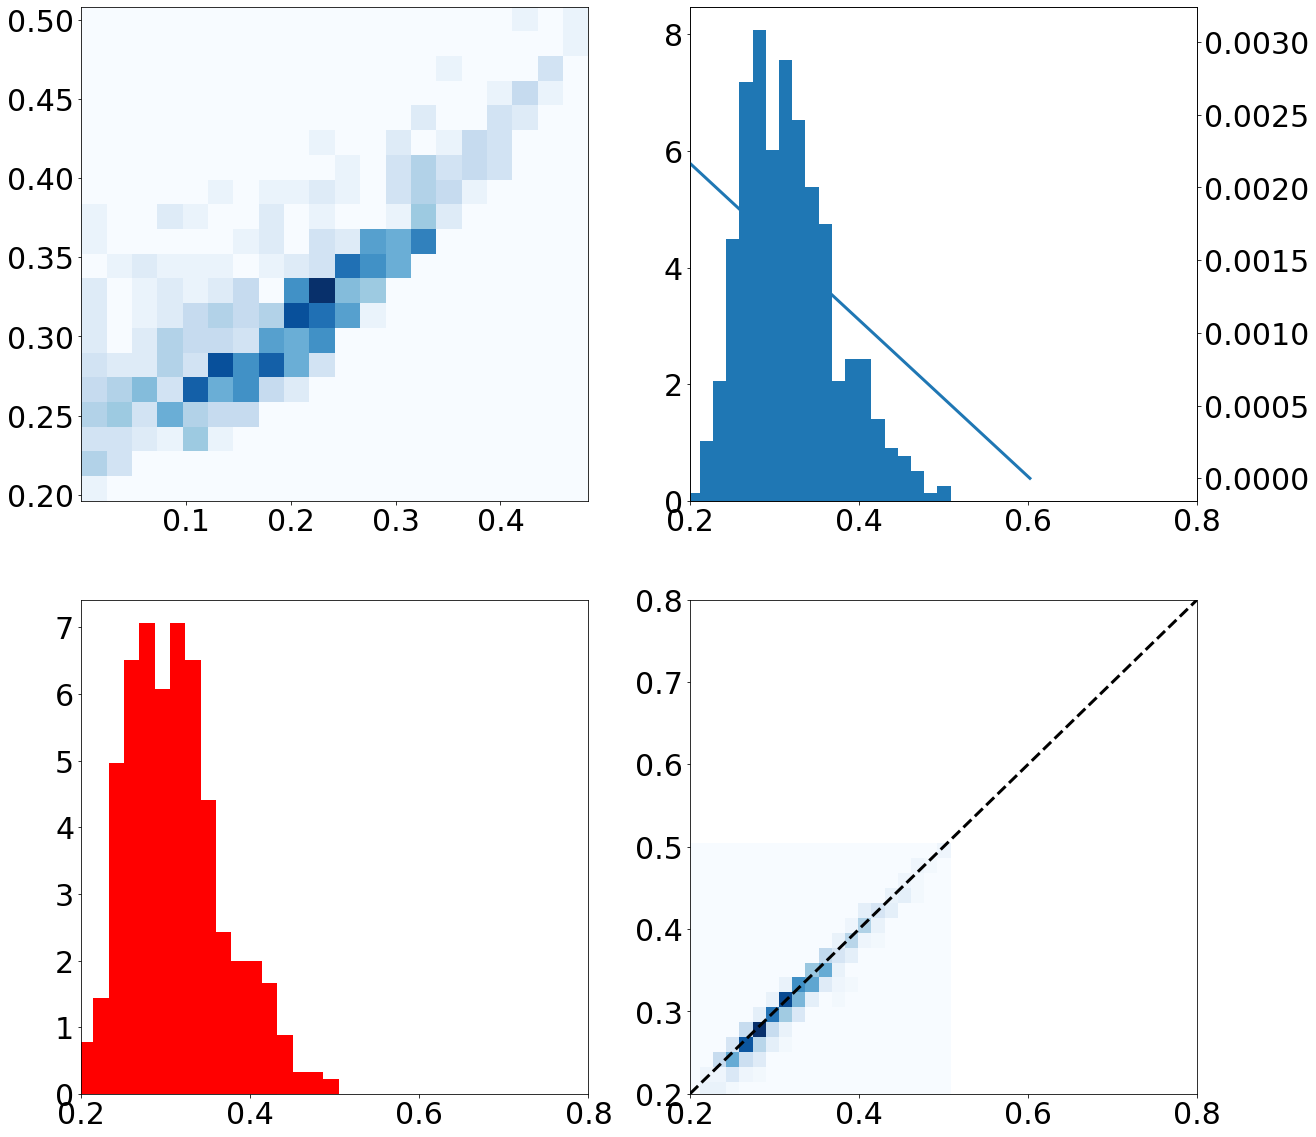

In [35]:
for kappa in kappa_s[kappa_s>=100][:-1]:
    qstring = f'xi=={xi} and infection_rate=={R0} and kappa=={kappa} and mutation_rate=={mu}'

    zx_predicted = z_df.query(qstring)['z_intersection_predicted'].values
    zx = z_df.query(qstring)['z_intersection'].values
    zb = z_df.query(qstring)['z_b'].values


    ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
    dt = ts_det[1]-ts_det[0]
    x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
    z_func = interp1d(ts_det,z)

    


    fig,ax= plt.subplots(2,2, figsize=(20,20))
    ax[0,1].hist(zx, bins=20,density=True)

    tax01 = ax[0,1].twinx()
    tax01.plot(z,y)


    # ax[0,1].plot(z,y)
    ax[1,0].hist(zx_predicted, bins=20,color='red',density=True)
    ax[1,1].hist2d( zx, zx_predicted, bins=20, cmap = plt.cm.Blues);
    ax[0,0].hist2d( zb, zx, bins=20, cmap = plt.cm.Blues);

    ax[1,1].plot([0,1],[0,1], color='black', linestyle='--')

    ax[1,1].set_ylim(0.2,.8)

    for a in ax.flatten()[1:]:
        a.set_xlim(0.2,.8)
        # a.set_ylim(0,1)

    


In [36]:
qdf

NameError: name 'qdf' is not defined

In [ ]:
for mu, R0 in funcs.product(mu_s,R0s):
    print(mu,R0)

1e-07 2.5
1e-07 4.5
1e-06 2.5
1e-06 4.5
1e-05 2.5
1e-05 4.5


/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

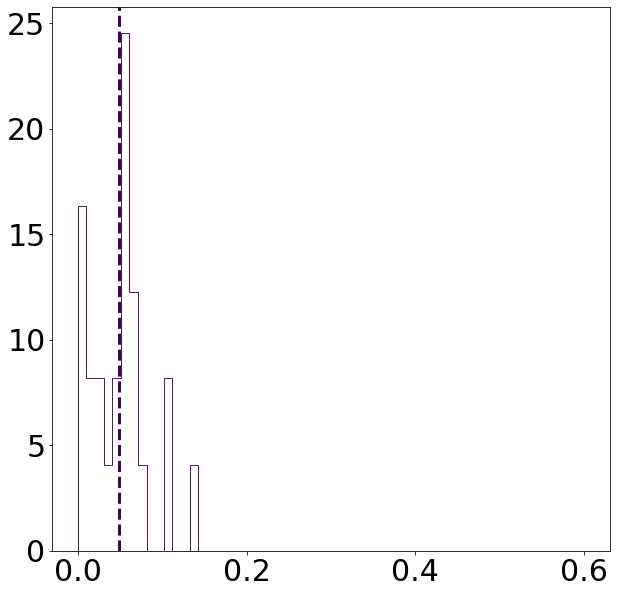

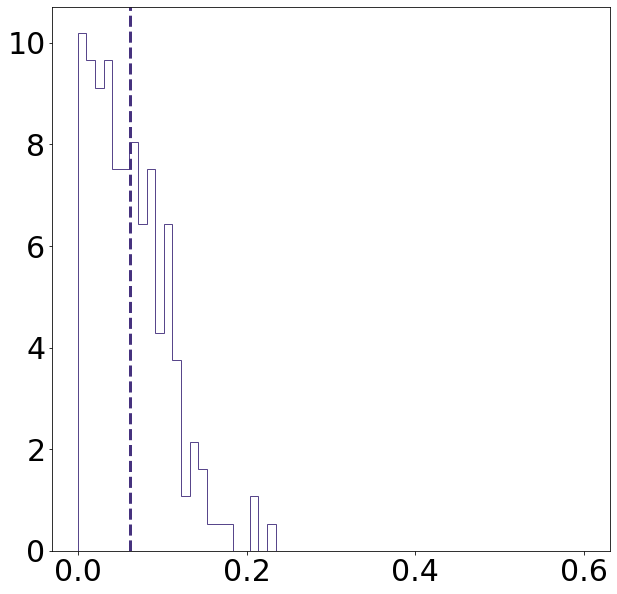

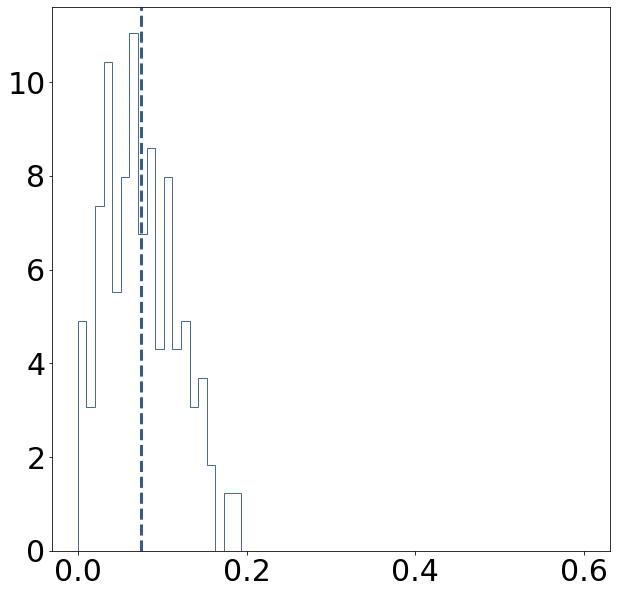

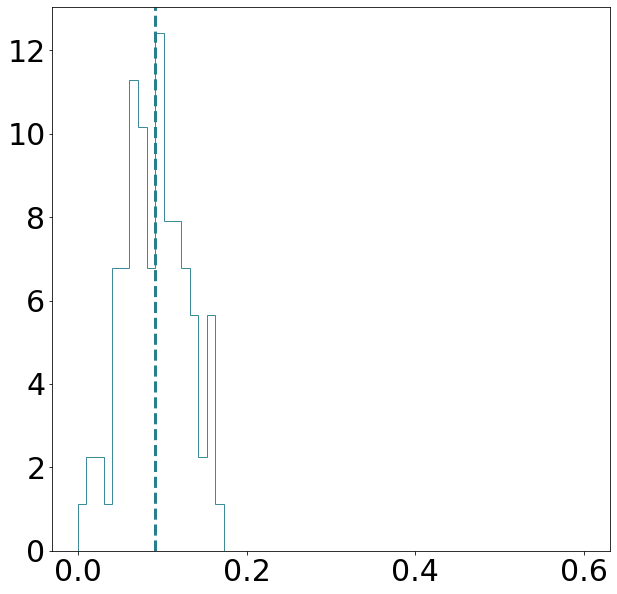

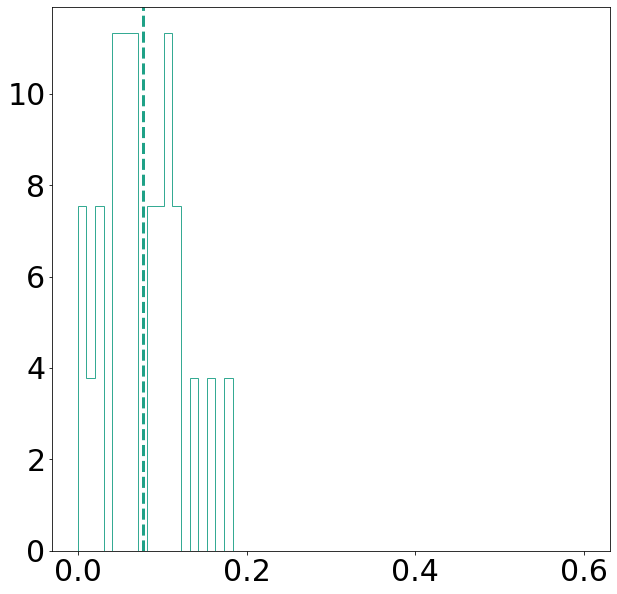

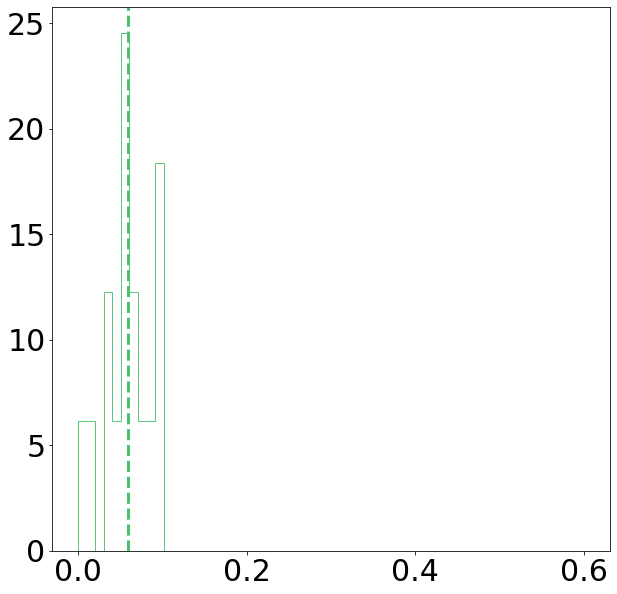

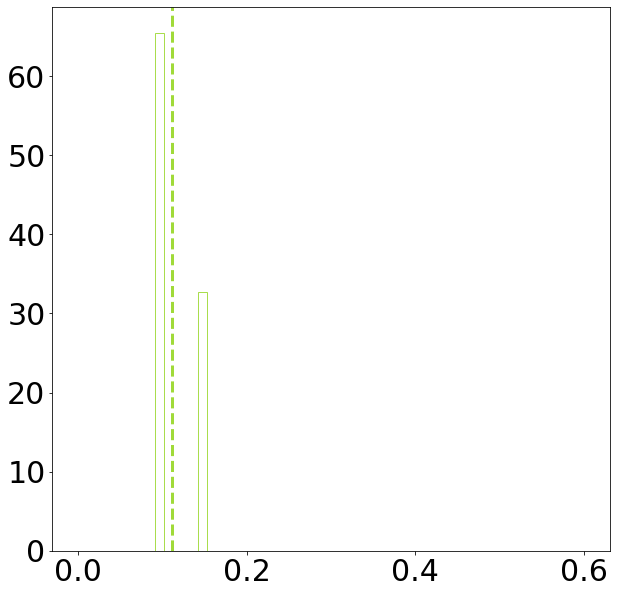

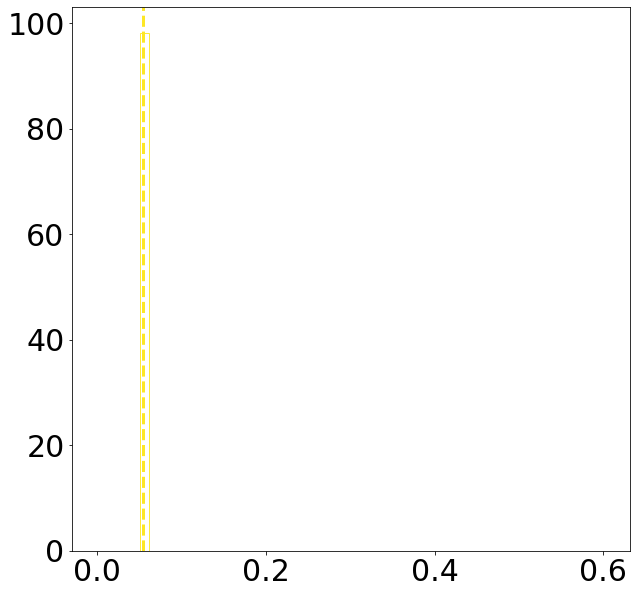

In [44]:
df = filtered_df
kappa = 1000
mu = mu_s[-1]
qstring = f'xi=={xi} and infection_rate=={R0} and kappa=={kappa} and mutation_rate=={mu}'

zx_predicted = z_df.query(qstring)['z_intersection_predicted'].values
zx = z_df.query(qstring)['z_intersection'].values
zb = z_df.query(qstring)['z_b'].values


ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
dt = ts_det[1]-ts_det[0]
x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
z_func = interp1d(ts_det,z)

qdf = df.query(f'infection_rate=={R0} and kappa=={kappa} and xi=={xi} and mutation_rate=={mu}')
qdf['z_intersection_predicted'] = qdf.apply(lambda row: get_z_intersection(z_func, row['first_d'], row['first_tb'], R0, N, xi, kappa), axis=1)
qdf['z_intersection'] = qdf.apply(lambda row: z_func(row['t_x']), axis=1)
qdf['z_b'] = qdf.apply(lambda row: z_func(row['first_tb']), axis=1)

#reset index of qdf
qdf = qdf.reset_index(drop=True)
ds=  np.arange(1, qdf['first_d'].max())
color_ds= funcs.color_dict(ds, plt.cm.viridis)

dd = 10
for d in ds[::dd]:
    fig,ax= plt.subplots(1,1, figsize=(10,10))
    ax.hist( qdf.query(f'first_d>={d} and first_d<{d+dd}')['z_b'].values, bins=np.linspace(0,1-1/R0*(1-R0/kappa),60),density=True, label=f'd={d}',alpha=.9,color=color_ds[d], histtype='step')
    ax.axvline(qdf.query(f'first_d>={d} and first_d<{d+dd}')['z_b'].mean(), color=color_ds[d], linestyle='--')
# tax = ax.twinx()
# tax.plot(z,y)
    # a.set_ylim(0,1)
# ax.set_xscale('log')

    


In [ ]:
mu_s

array([1.e-07, 1.e-06, 1.e-05])

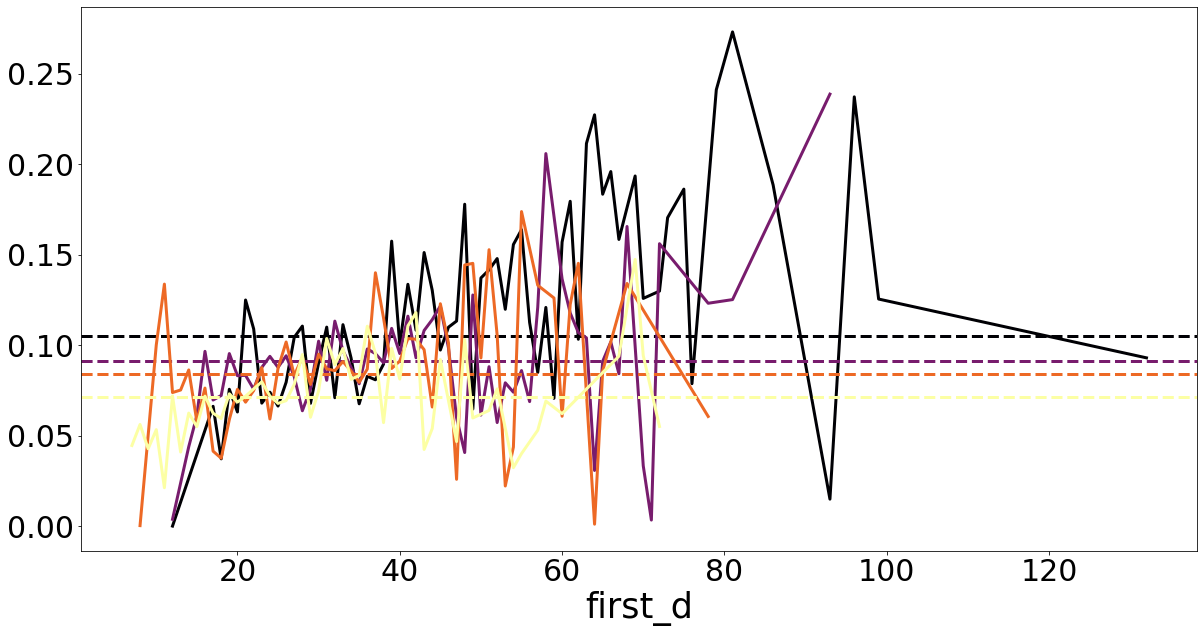

In [ ]:
#average zb for each d
mu = mu_s[-1]
plt.figure(figsize=(20,10))
for kappa in kappa_s[kappa_s>=100]:

    ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
    dt = ts_det[1]-ts_det[0]
    x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
    z_func = interp1d(ts_det,z)

    qdf = df.query(f'infection_rate=={R0} and kappa=={kappa} and xi=={xi} and mutation_rate=={mu}')
    qdf['z_b'] = qdf.apply(lambda row: z_func(row['first_tb']), axis=1)
    qdf.groupby('first_d')['z_b'].mean().plot(color=colors_kappa[kappa], label=f'kappa={kappa}')
    plt.axhline( qdf['z_b'].mean(),color=colors_kappa[kappa], linestyle='--')


In [ ]:
ds

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.])

In [ ]:
qdf

,RunId,iteration,Step,N,infection_rate,kappa,p_alpha,mutation_rate,xi,recovery_rate,...,first_d_over_xi,$R_0$,$\mu N$,t_first_times_muN,t_first_times_mu,exp_number_mutants,rescaled_first_tb,z_intersection_predicted,z_intersection,z_b
31,56,0,11108,100000000,2.5,1000.0,0.1,1.000000e-06,20.0,1,...,0.80,2.5,100.0,10494.643702,0.000105,0.0602,0.262366,0.214266,0.2182088339538039,0.13008376164488725
35,55,0,27053,100000000,2.5,1000.0,0.1,1.000000e-07,50.0,1,...,0.68,2.5,10.0,4295.415229,0.000043,0.0301,1.073854,0.401486,0.4059070647518337,0.39182202906540087
38,54,0,29837,100000000,2.5,1000.0,0.1,1.000000e-07,20.0,1,...,1.70,2.5,10.0,4875.351235,0.000049,0.0602,1.218838,0.427522,0.4275621172179134,0.42005691813799795
57,57,0,30101,100000000,2.5,1000.0,0.1,1.000000e-06,50.0,1,...,0.68,2.5,100.0,48486.369814,0.000485,0.0301,1.212159,0.426390,0.4294898591980669,0.4188374627265385
67,58,0,8570,100000000,2.5,1000.0,0.1,1.000000e-05,20.0,1,...,0.85,2.5,1000.0,7811.382939,0.000078,0.0602,0.019528,0.141418,0.17485991662699174,0.0018103073176467751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59889,59934,499,52730,100000000,2.5,1000.0,0.1,1.000000e-07,20.0,1,...,1.10,2.5,10.0,8788.313039,0.000088,0.0602,2.197078,0.535011,0.5350992477584467,0.5329700002427348
59892,59936,499,19396,100000000,2.5,1000.0,0.1,1.000000e-06,20.0,1,...,0.15,2.5,100.0,8472.476170,0.000085,0.0602,0.211812,0.300044,0.3313405482927829,0.10565765232501034
59893,59937,499,15785,100000000,2.5,1000.0,0.1,1.000000e-06,50.0,1,...,0.24,2.5,100.0,5410.481689,0.000054,0.0301,0.135262,0.200189,0.2868806779570454,0.06625298957314626
59902,59939,499,8352,100000000,2.5,1000.0,0.1,1.000000e-05,50.0,1,...,1.28,2.5,1000.0,28607.921932,0.000286,0.0301,0.071520,0.143339,0.17092488764192043,0.031067573781075053


In [38]:
def get_z_intersection(zfunc, d,tb, R0, N, xi, kappa):
    #to solve: - Log(N*(1-c(d)))
    s_d_z= lambda z,d : (1-np.exp(-d/xi))*z/(1-z)
    to_solve = lambda zx, z,d : - np.log(-1 + N*s_d_z(z,d)*((-1 + R0*(1 - z)))/kappa) - (kappa*(1 - np.exp(-d/xi))*((-1 + R0)*np.log((-1 + R0*(1 - zx))/(-1 + R0*(1 - z))) + R0*np.log((1 - z)/(1 - zx))))/R0

    zstart =zfunc(tb)
    zx= spo.fsolve(to_solve, .5, args=(zstart, d))
    return zx[0]

In [45]:
kappa =1000
ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
dt = ts_det[1]-ts_det[0]
x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
z_func = interp1d(ts_det,z)

ds = np.linspace(0,z_df['first_d'].max())
zs = z_func(ts_det)

zx_dz = np.zeros((len(ds), len(zs)))
for i_d, d in enumerate(ds):
    zx_dz[i_d, :] = np.array([get_z_intersection(z_func, d, tb, R0, N, xi, kappa) for tb in ts_det])

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [ ]:
zx_integral_dz = zx_dz
cs = np.exp(-ds/xi)

integral_cs = cs**(xi*p_alpha)


weights = (np.exp(-mu*N*zx_integral_dz.T*integral_cs/100) *cs**(xi*p_alpha-1)).T



<AxesSubplot:xlabel='first_d', ylabel='Probability'>

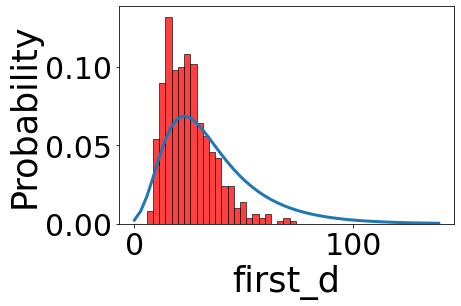

In [ ]:
qdf = df.query(f'infection_rate=={R0} and kappa=={kappa} and xi=={xi} and mutation_rate=={mu}')
plt.plot(ds, weights.sum(axis=1)/weights.sum())
sns.histplot(qdf['first_d'], bins=ds, stat='probability', color='red', label='weighted')

(0.0, 245.60907658603156, -7.329404736443324e-05, 0.0015391755993275863)

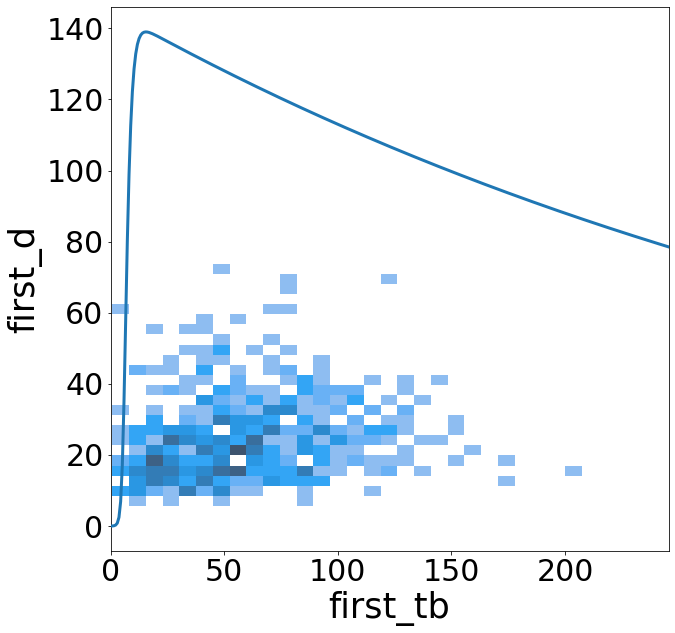

In [ ]:
R0=2.5
xi=20
ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),10000)
x,y,z = odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
qdf = filtered_df.query(f'infection_rate=={R0} and kappa=={kappa} and xi=={xi} and mutation_rate=={mu}')
fig,ax= plt.subplots(1,1, figsize=(10,10))

sns.histplot(qdf, x='first_tb', y='first_d', bins=(ts_det[1::10],ds), stat='probability', ax=ax)
tax = ax.twinx()
tax.plot(ts_det,y)
# ax.set_xscale('log')
ax.set_xlim(0,20/(R0-1)*np.log(N))
tax.set_xlim(0,20/(R0-1)*np.log(N))
tax.axis('off')

In [ ]:
import math

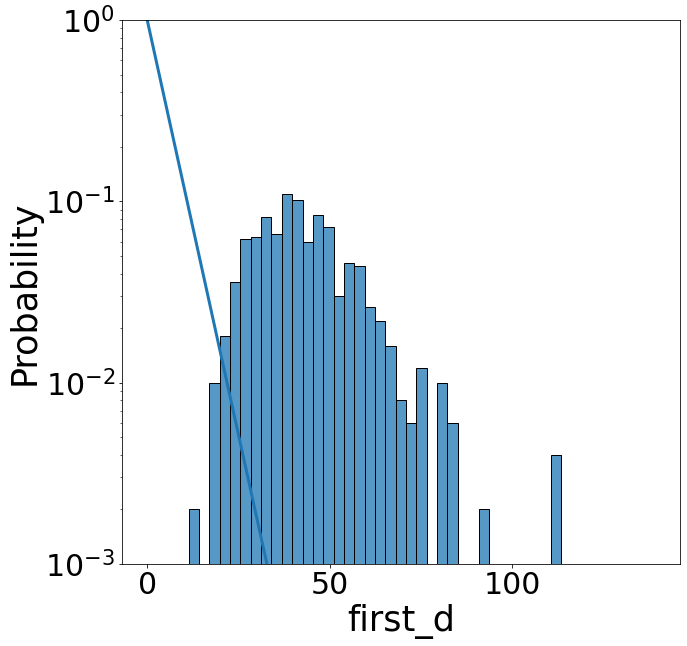

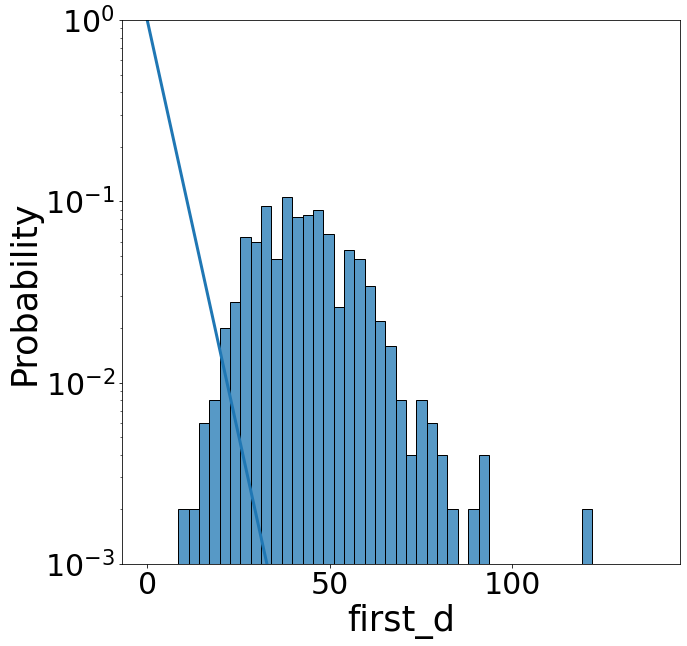

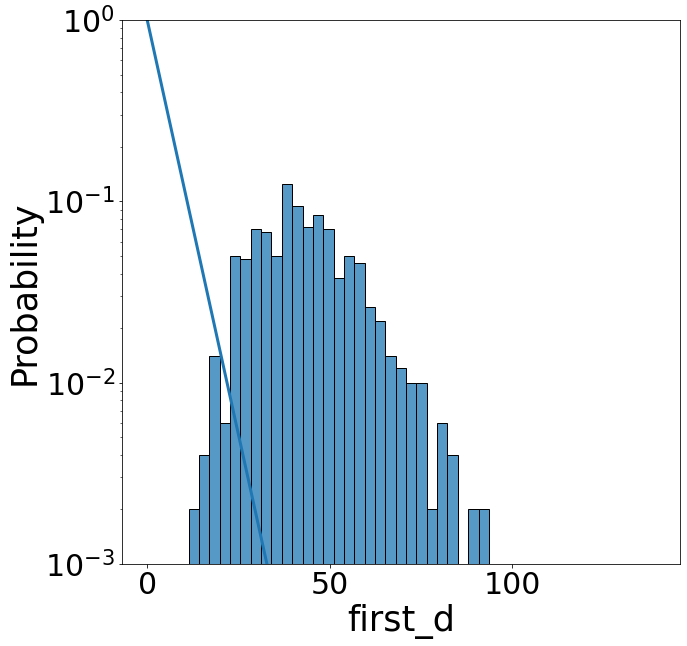

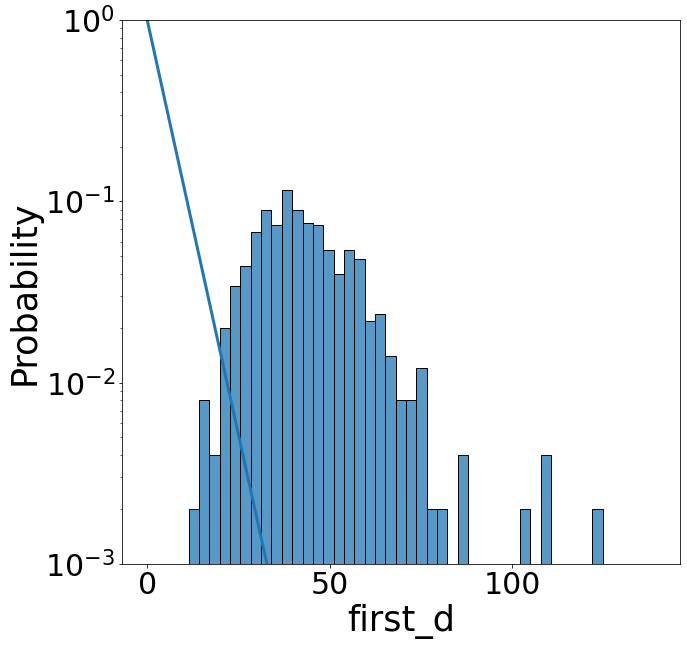

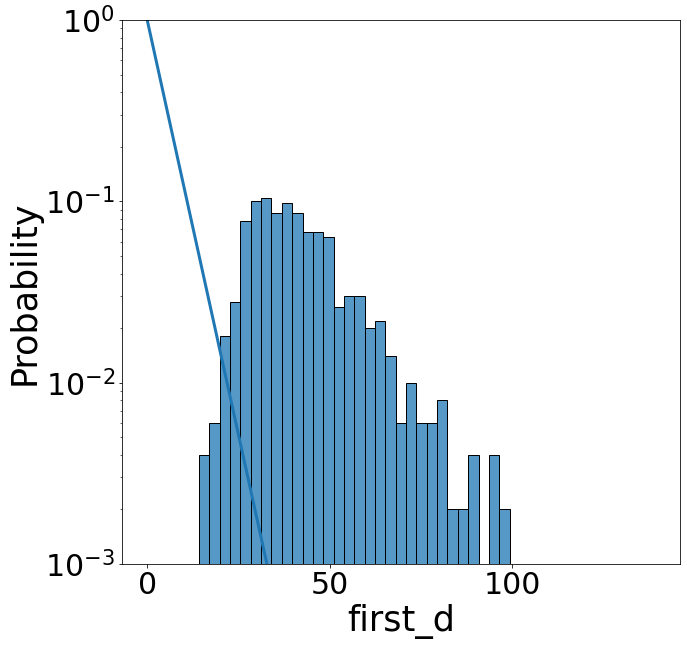

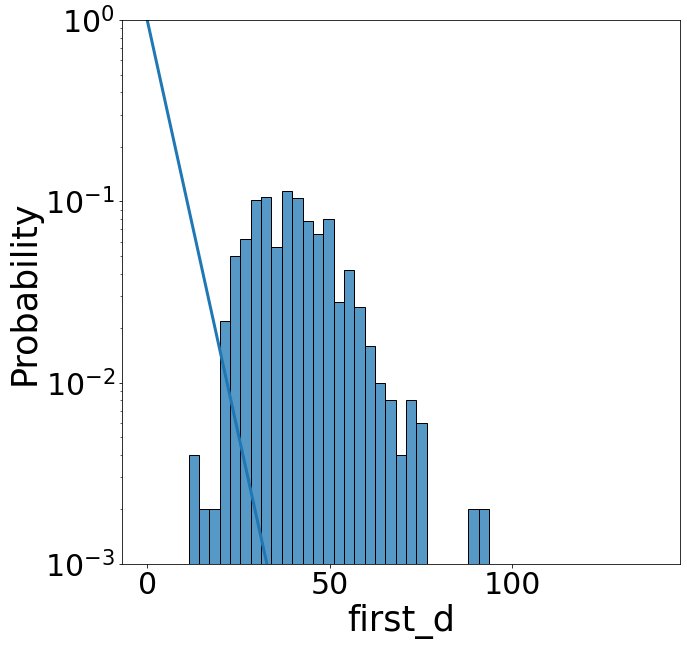

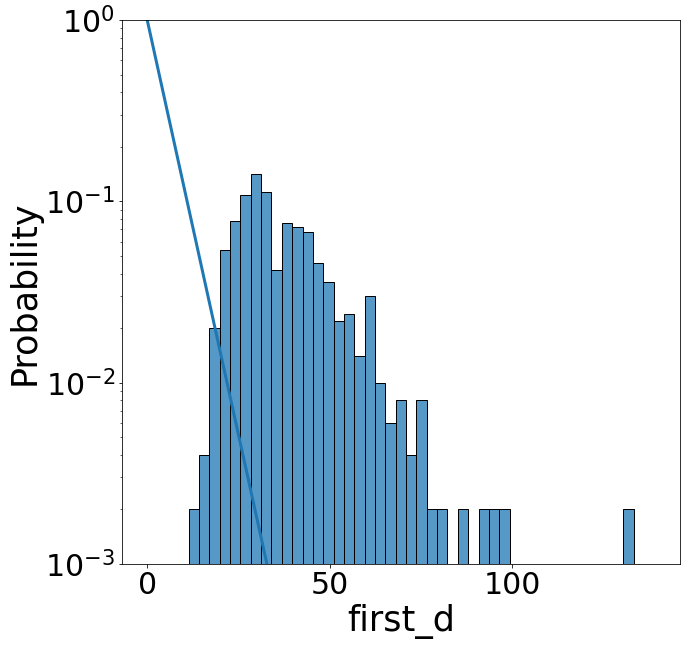

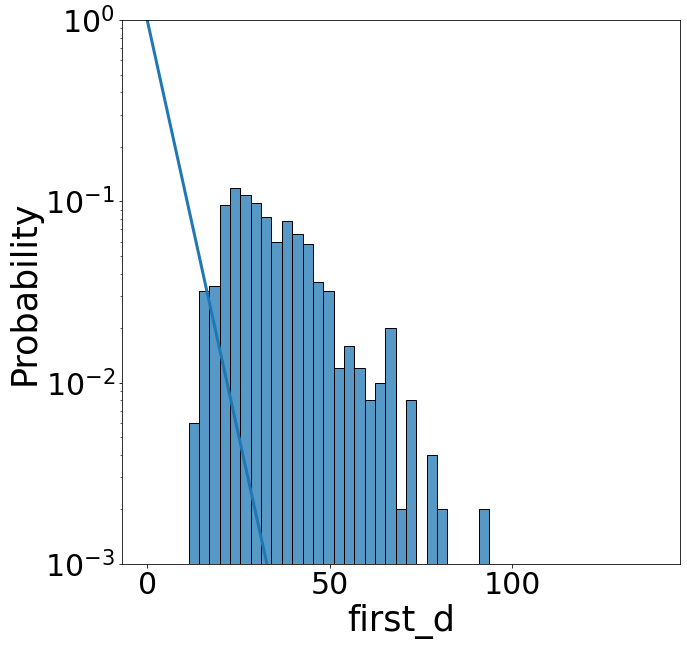

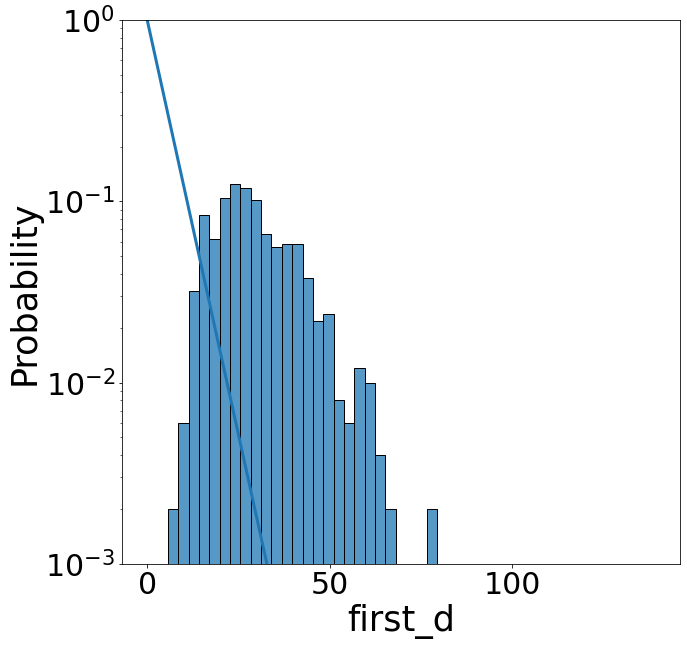

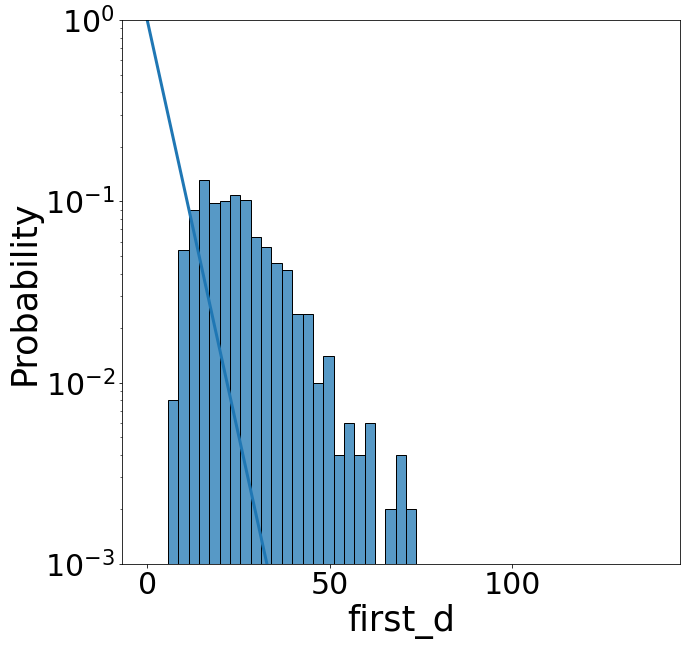

In [ ]:
for kappa in kappa_s:
    qdf= filtered_df.query(f'infection_rate=={R0} and kappa=={kappa} and xi=={xi} and mutation_rate=={mu}')
    fig,ax = plt.subplots(1,1, figsize=(10,10))
    sns.histplot(qdf, x = 'first_d', bins=(ds), stat='probability', ax=ax)
    ax.plot(ds, np.exp(2*-ds/xi_d), label='c(d)')
    ax.set_yscale('log')
    ax.set_ylim(1e-3,1)

In [47]:
#turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [39]:
#zx eq : \[Kappa]*(Log(1 - zX) - Log(1 - 2/(1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d)))) +((-1 + R0)*(-Log(-1 + R0 - R0*zX) + Log(-1 + R0 - (2*R0)/(1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d))))))/R0) +((Log(N0) - Log(\[Kappa]) + Log(2 - 2*c(d)) - Log(1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d))) - Log(1 - 2/(1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d)))) +Log(-1 + R0 - (2*R0)/(1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d)))))*(-1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d))))/(2.*(-1 + c(d)))
R_d = lambda d, p_alpha:(1-p_alpha)**(d)
# R_d = lambda d, p_alpha: p_alpha*(1-p_alpha)**(d)
c_d = lambda d, xi: np.exp(-d/xi)
zx_eqn = lambda zx, d, kappa, R0, mu, N, xi, p_alpha: kappa*(np.log(1-zx) - np.log(1-2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))) + ((-1+R0)*(-np.log(-1+R0-R0*zx) + np.log(-1+R0-(2*R0)/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha))))))/R0) + ((np.log(N) - np.log(kappa) + np.log(2-2*c_d(d,xi)) - np.log(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))) + np.log(-1+R0-(2*R0)/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))))*(-1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))/(2*(-1+c_d(d,xi)))

#zx_eq2 =         \[Kappa]*(Log((1 - zX)/(1 - 2/(1 + Sqrt(1 + 4*\[Mu]N*(1 - c(d))*\[Rho](d))))) + ((-1 + R0)*Log((-1 + R0*(1 - 2/(1 + Sqrt(1 + 4*\[Mu]N*(1 - c(d))*\[Rho](d)))))/(-1 + R0*(1 - zX))))/R0) -(Log((N0*(-1 + R0*(1 - 2/(1 + Sqrt(1 + 4*\[Mu]N*(1 - c(d))*\[Rho](d))))))/\[Kappa])*(1 + Sqrt(1 + 4*\[Mu]N*(1 - c(d))*\[Rho](d)))*(1 - 2/(1 + Sqrt(1 + 4*\[Mu]N*(1 - c(d))*\[Rho](d)))))/(2.*(1 - c(d)))
zx_eqn2 = lambda zx, d, kappa, R0, mu, N, xi, p_alpha: kappa*(np.log((1-zx)/(1-2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))) + ((-1+R0)*np.log((-1+R0*(1-2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))))/(-1+R0*(1-zx))))/R0) - (np.log((N*(-1+R0*(1-2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha))))))/kappa)*(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))*(1-2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))))/(2*(1-c_d(d,xi))))

# zx_eq_W = 

#zb_func = 2/(1 + Sqrt[1 + 4 \[Mu]N (1 - c[d]) \[Rho][d]])
zb_func = lambda d, mu, N, xi: 2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))

def get_zx(zx_eqn, d, kappa, R0, mu, N, xi, p_alpha, ax= None):
    #find zero of zx_eqn
    zxs_to_test= np.linspace(0,1,1000)
    zx_eqn_vals = zx_eqn(zxs_to_test, d, kappa, R0, mu, N, xi, p_alpha)
    zx_eqn_vals[np.isnan(zx_eqn_vals)] = np.inf
    if ax is not None:
        ax.plot(zxs_to_test, zx_eqn_vals)
    zx = zxs_to_test[np.argmin(np.abs(zx_eqn_vals))]
    return zx

def get_zx2(zx_eqn2, d, kappa, R0, mu, N, xi, p_alpha, ax= None):
    #find zero of zx_eqn
    zxs_to_test= np.linspace(0,1,1000)
    zx_eqn_vals = zx_eqn2(zxs_to_test, d, kappa, R0, mu, N, xi, p_alpha)
    zx_eqn_vals[np.isnan(zx_eqn_vals)] = np.inf
    if ax is not None:
        ax.plot(zxs_to_test, zx_eqn_vals)
    zx = zxs_to_test[np.argmin(np.abs(zx_eqn_vals))]
    return zx


In [143]:
#zx_z_to_solve = \[Kappa]*(1 - c(d))*(-(((-1 + R0)*Log((-1 + R0*(1 - zx))/(-1 + R0*(1 - z0))))/R0) + Log((1 - zx)/(1 - z0))) - Log((N0*(-1 + R0*(1 - z))*z*(1 - c(d)))/((1 - z)*\[Kappa]))
zx_z_to_solve= lambda zx, z, d, kappa, R0, N, xi,: kappa*(1-c_d(d,xi))*(-(((-1+R0)*np.log((-1+R0*(1-zx))/(-1+R0*(1-z))))/R0) + np.log((1-zx)/(1-z))) - np.log((N*(-1+R0*(1-z))*z*(1-c_d(d,xi)))/((1-z)*kappa))

def get_zx_z(zx_z_to_solve, z, d, kappa, R0, N, xi, ax= None):
    #find zero of zx_eqn
    # zxs_to_test= np.linspace(0,1,10000)
    # zx_z_to_solve_vals = np.array([zx_z_to_solve(zz, z, d, kappa, R0, N, xi) for zz in zxs_to_test])
    # zx_z_to_solve_vals[np.isnan(zx_z_to_solve_vals)] = np.inf

    #do the same but use a solver
    zx = spo.fsolve(zx_z_to_solve,.5 , args=(z, d, kappa, R0, N, xi))

    # if ax is not None:
    #     ax.plot(zxs_to_test, zx_z_to_solve_vals)
    # try:
    #     zx = zxs_to_test[np.where(np.diff(np.sign(zx_z_to_solve_vals)))[0][0]]
    #     # print(zx)
    # except IndexError:
    #     zx = np.nan
    return zx

def get_zx_no_solver(zx_z_to_solve,z,d,kappa,R0,N,xi):
    #find zero of zx_eqn
    zxs_to_test= np.linspace(0,1,10000)
    zx_z_to_solve_vals = np.array([zx_z_to_solve(zz, z, d, kappa, R0, N, xi) for zz in zxs_to_test])
    zx_z_to_solve_vals[np.isnan(zx_z_to_solve_vals)] = np.inf
    try:
        zx = zxs_to_test[np.where(np.diff(np.sign(zx_z_to_solve_vals)))[0][0]]
        # print(zx)
    except IndexError:
        zx = np.nan
    return zx

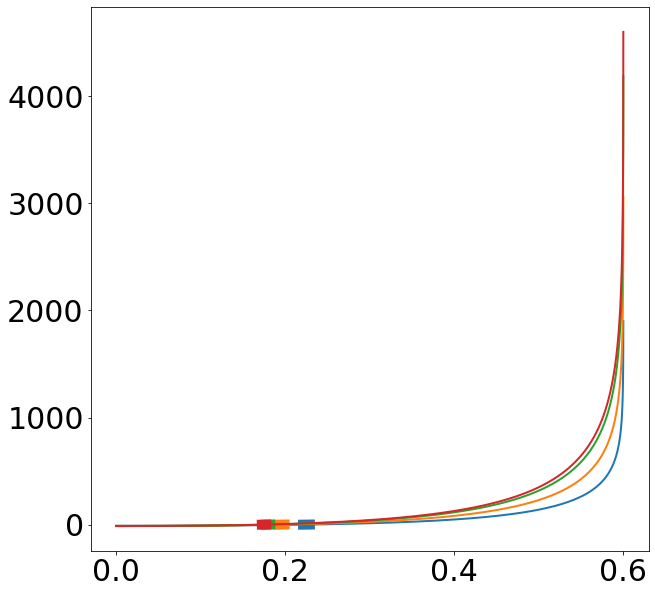

In [116]:
#test zx_z_to_solve
fig,ax = plt.subplots(1,1, figsize=(10,10))
z = 0.1
zxs_to_test= np.linspace(0,1,10000)

for d in [10,20, 40,60]:

    zx_z_to_solve_vals = np.array([zx_z_to_solve(zz, z, d, kappa, R0, N, xi) for zz in zxs_to_test])
    ll, =ax.plot(zxs_to_test[np.logical_and(zx_z_to_solve_vals>0,zx_z_to_solve_vals<1)], zx_z_to_solve_vals[np.logical_and(zx_z_to_solve_vals>0,zx_z_to_solve_vals<1)],lw=10)
    ax.plot(zxs_to_test, zx_z_to_solve_vals, color=ll.get_color(),lw=2)



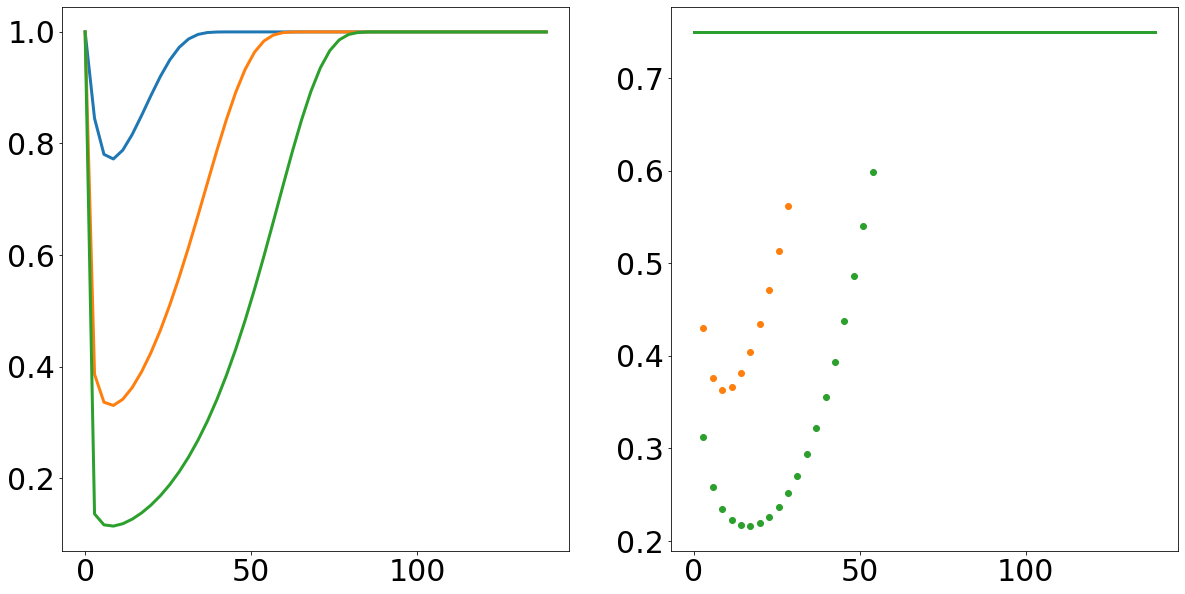

In [142]:
z_est = lambda d, mu, N, xi, p_alpha: 1 + np.real(sps.lambertw(-np.exp(-1 - np.power(N*mu*R_d(d,p_alpha)*(1-c_d(d,xi)),-1)))) 
fig,ax= plt.subplots(1,2, figsize=(20,10))
mu,N, xi, p_alpha = mu_s[-1], N, xi_s[0], p_alpha
for mu in mu_s:

    ax[0].plot(ds, z_est(ds, mu, N, xi, p_alpha))
    zx_correspondant = [np.array(get_zx_z(zx_z_to_solve, z_est(d, mu, N, xi, p_alpha),d, kappa, R0, N, xi)) for d in ds]
    zx_nosolver= [np.array(get_zx_no_solver(zx_z_to_solve, z_est(d, mu, N, xi, p_alpha),d, kappa, R0, N, xi)) for d in ds]

    
    # print(zx_correspondant)
    solved, =ax[1].plot(ds, zx_correspondant)
    ax[1].plot(ds, zx_nosolver,marker='o', color=solved.get_color(), linestyle='None')
    # ax[1].set_ylim(-1000,1)

In [138]:
np.array((zx_correspondant)).flatten()

array([0.5       , 0.31286946, 0.25876146, 0.23469374, 0.22248063,
       0.21696576, 0.21619052, 0.21937174, 0.22626672, 0.23691608,
       0.25151598, 0.27034268, 0.29370133, 0.32188704, 0.355151  ,
       0.39366559, 0.43748296, 0.48648294, 0.54030954, 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ])

In [41]:
z_inf_func = lambda R0,kappa: 1-R0/kappa * (1-R0/kappa)

In [49]:
t_peaks = {}
for R0 in R0s:
    t_peaks_R0= []
    for kappa in kappa_s:
        ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),5000)
        x,y,z = odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
        tp = ts_det[np.argmax(y)]
        t_peaks_R0.append(tp)
    t_peaks[R0] = np.array(t_peaks_R0)


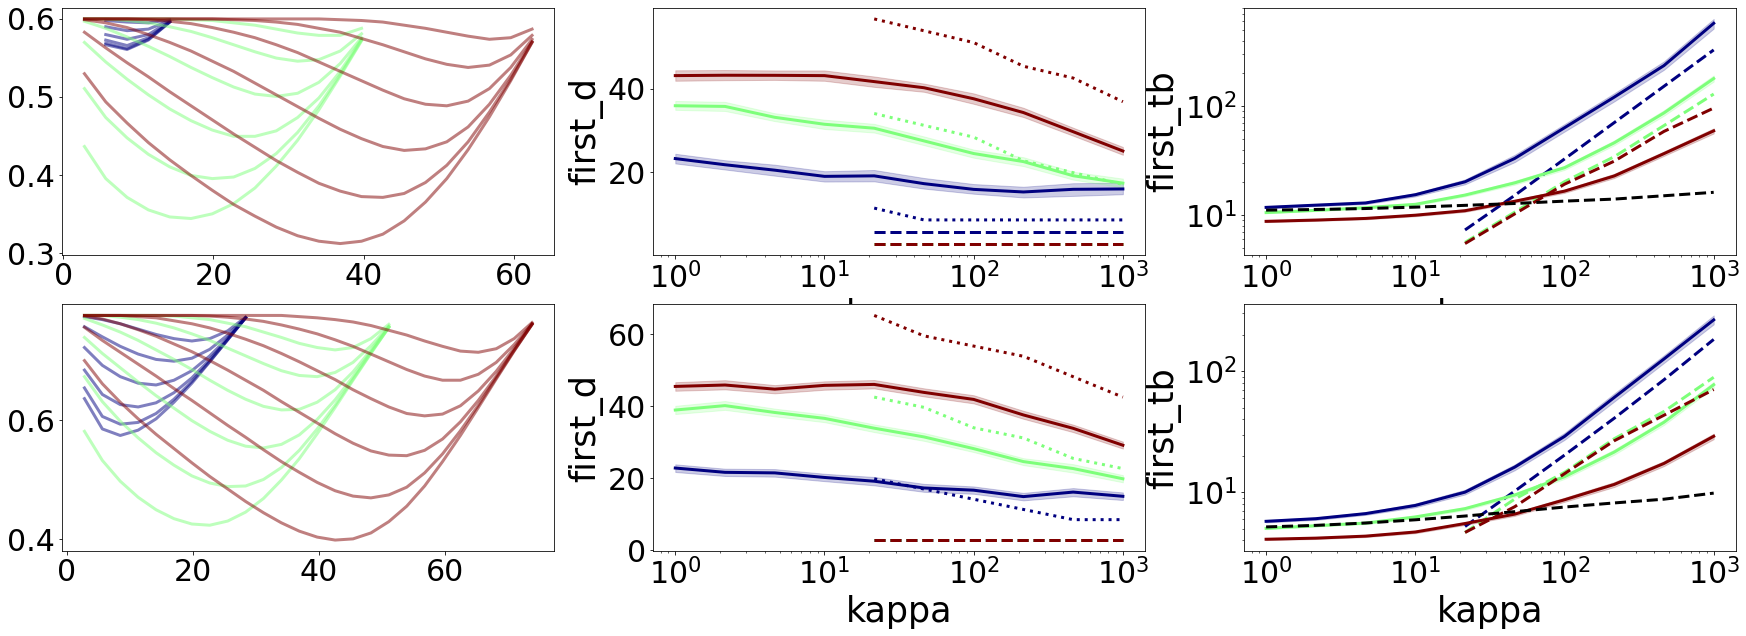

In [50]:
R0 = 2.5
mu = mu_s[-1]
colors_mu = funcs.color_dict(mu_s,plt.cm.jet)
fig,ax= plt.subplots(2,3, figsize=(30,10))
ax = ax.T

for i, R0 in enumerate(R0s):
    

    for mu in mu_s:
        d_mins = []
        d_mins2=  []
        zx_mins = []
        for kappa in kappa_s[kappa_s>10]:
            
            zxd = np.array([get_zx(zx_eqn, d, kappa,R0,mu, N, xi, p_alpha) for d in ds])
            zxd2 = np.array([get_zx2(zx_eqn2, d, kappa,R0,mu, N, xi, p_alpha) for d in ds])
            ds_reduced = ds[zxd>0]
            zxd_reduced = zxd[zxd>0]

            ds_reduced2 = ds[zxd2>0]
            zxd_reduced2 = zxd2[zxd2>0]

            try:
                d_min = ds_reduced[np.argmin(zxd_reduced)]
                d_mins.append(d_min)
                zx_mins = zxd_reduced[np.argmin(zxd_reduced)]
            except ValueError:
                print(d_mins)
                d_mins.append(np.nan)

            try: 
                d_min2 = ds_reduced2[np.argmin(zxd_reduced2)]
                d_mins2.append(d_min2)
            except ValueError:
                print(d_mins2)
                d_mins2.append(np.nan)

            ax[0,i].plot(ds_reduced, zxd_reduced,alpha=.5,color=colors_mu[mu])

        d_mins = np.array(d_mins)
        cl, = ax[1,i].plot(kappa_s[kappa_s>10], d_mins,linestyle=':',color=colors_mu[mu])
        cl2, = ax[1,i].plot(kappa_s[kappa_s>10], d_mins2,linestyle='--',color=colors_mu[mu])
        zb_mins = zb_func(d_mins, mu, N, xi)
        tb_mins = kappa_s[kappa_s>10]/R0*np.log(z_inf_func(R0,kappa)/(z_inf_func(R0,kappa)-zb_mins))
        ax[2,i].plot(kappa_s[kappa_s>10], tb_mins,linestyle='--',color=colors_mu[mu])
        # ax[1].plot(kappa_s[kappa_s>R0], d_mins2,linestyle='--',color=colors_mu[mu])
        sns.lineplot(data =filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}'), x='kappa', y='first_d', ax=ax[1,i], color=cl.get_color())
        sns.lineplot(data =filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}'), x='kappa', y='first_tb', ax=ax[2,i], color=cl.get_color())
    ax[1,i].set_xscale('log')
    ax[2,i].set_xscale('log')
    ax[2,i].set_yscale('log')
    ax[2,i].plot(kappa_s,t_peaks[R0], color='black', linestyle='--')



In [51]:
from scipy import stats


mode = lambda m: stats.mode(m)[0][0]

def smooth_mode(m):
    x = np.linspace(m.min(), m.max(), 1000)
    kde = stats.gaussian_kde(m)
    y = kde(x)
    return x[np.argmax(y)]


In [52]:
filtered_df['scaled_first_d'] = filtered_df['first_d']*filtered_df['p_alpha']
filtered_df['scaled_first_tb'] = filtered_df['first_tb']/filtered_df['kappa']*filtered_df['infection_rate']

In [53]:
d_mins_mu_kappa = {}
for mu in tqdm(mu_s):
    d_mins = []
    d_mins2=  []
    zx_mins = []
    for kappa in kappa_s[kappa_s>10]:
        
        zxd = np.array([get_zx(zx_eqn, d, kappa,R0,mu, N, xi, p_alpha) for d in ds])
        zxd2 = np.array([get_zx2(zx_eqn2, d, kappa,R0,mu, N, xi, p_alpha) for d in ds])
        ds_reduced = ds[zxd>0]
        zxd_reduced = zxd[zxd>0]

        ds_reduced2 = ds[zxd2>0]
        zxd_reduced2 = zxd2[zxd2>0]

        try:
            d_min = ds_reduced[np.argmin(zxd_reduced)]
            d_mins.append(d_min)
            zx_mins = zxd_reduced[np.argmin(zxd_reduced)]
        except ValueError:
            print(d_mins)
            d_mins.append(np.nan)

        try: 
            d_min2 = ds_reduced2[np.argmin(zxd_reduced2)]
            d_mins2.append(d_min2)
        except ValueError:
            print(d_mins2)
            d_mins2.append(np.nan)

        # ax[0,i].plot(ds_reduced, zxd_reduced,alpha=.5,color=colors_mu[mu])

    d_mins = np.array(d_mins)
    d_mins_mu_kappa[mu] = d_mins
    

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:09<00:00,  3.23s/it]


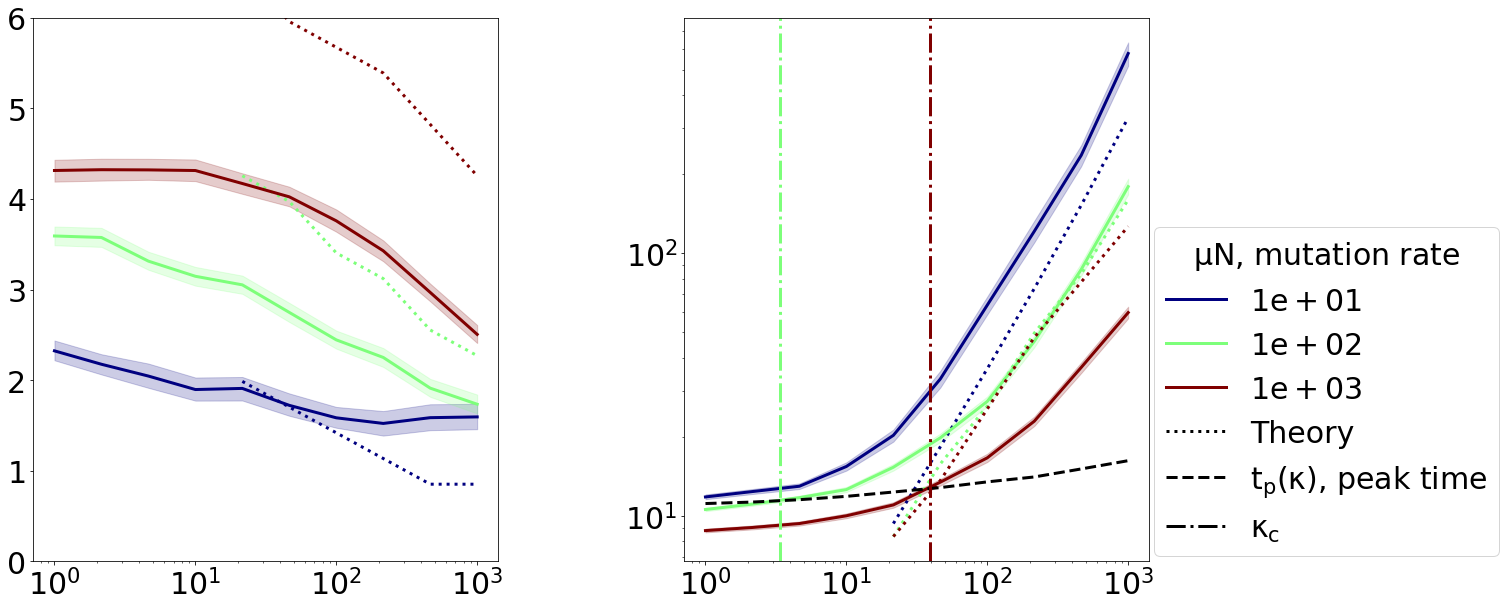

In [65]:
R0 = 2.5
mu = mu_s[-1]
colors_mu = funcs.color_dict(mu_s,plt.cm.jet)
fig,ax= plt.subplots(1,2, figsize=(20,10))
plt.subplots_adjust(wspace=.4)
ax = ax.T
# for i, R0 in enumerate(R0s):
        
for mu in tqdm(mu_s):

    cl, = ax[0].plot(kappa_s[kappa_s>10], (d_mins_mu_kappa[mu])*p_alpha,linestyle=':',color=colors_mu[mu])
    zb_mins = zb_func(d_mins_mu_kappa[mu], mu, N, xi)
    tb_mins = kappa_s[kappa_s>10]/R0*np.log(z_inf_func(R0,kappa)/(z_inf_func(R0,kappa)-zb_mins))
    ax[1].plot(kappa_s[kappa_s>10], tb_mins,linestyle=':',color=colors_mu[mu])
    # ax[1].plot(kappa_s[kappa_s>R0], d_mins2,linestyle='--',color=colors_mu[mu])
    sns.lineplot(data =filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}'), x='kappa', y='scaled_first_d', ax=ax[0], color=cl.get_color(), estimator = np.mean)
    sns.lineplot(data =filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}'), x='kappa', y='first_tb', ax=ax[1], color=cl.get_color(), estimator = np.mean, label = f'${mu*N:.0e}$')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_ylabel('')
ax[1].set_ylabel('')

handles, labels = ax[1].get_legend_handles_labels()
handles += [Line2D([0], [0], color='k', linestyle=':', label='Theory'), Line2D([0], [0], color='k', linestyle='--', label=r'$t_\mathrm{p}(\kappa)$, peak time'),
            Line2D([0], [0], color='k', linestyle='-.', label=r'$\kappa_c$')]
ax[1].legend(handles=handles, title = '$\mu N$, mutation rate',loc=(1.01,.01), fontsize= 30, title_fontsize=30)

ax[1].plot(kappa_s,t_peaks[R0], color='black', linestyle='--')
for mu in mu_s:
    ax[1].axvline(mu*N/(10*R0) - (R0-1)/R0, color=colors_mu[mu], linestyle='-.')

ax[0].set_ylim(0,6)
# ax[0,i].set_title(f'xi={xi}, R0={R0}')

plt.savefig(results_folder + f'/first_d_tb_{xi}.pdf', dpi=300,bbox_inches='tight')


In [64]:
os.listdir(results_folder)

['01-10-19--04-06-2023abm_result_featherp_evo_df.feather',
 'first_d_tb_20.0.pdf']

In [ ]:
np.log10(N)

8.0

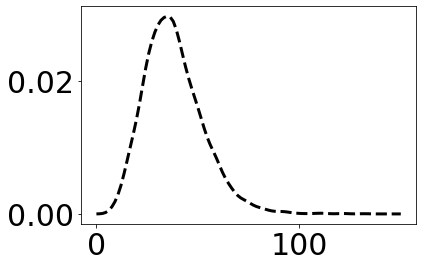

In [ ]:
#get kde array of first_d
qfiltered = filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}')
kde = stats.gaussian_kde(qfiltered['first_d'].values)
x = np.linspace(0,150,100)
plt.plot(x,kde(x),color='k',linestyle='--')


In [ ]:
lambda_d_t = lambda d,t, mu,N ,yp, zp, p_alpha ,xi:   mu* N* yp * zp/(1-zp)*(1-p_alpha)**d*(1- np.exp(-d/xi)/(1+1/(p_alpha*xi)))* ( t + np.log(N*yp)/((1-np.exp(-d/xi))*zp/(1-zp)))

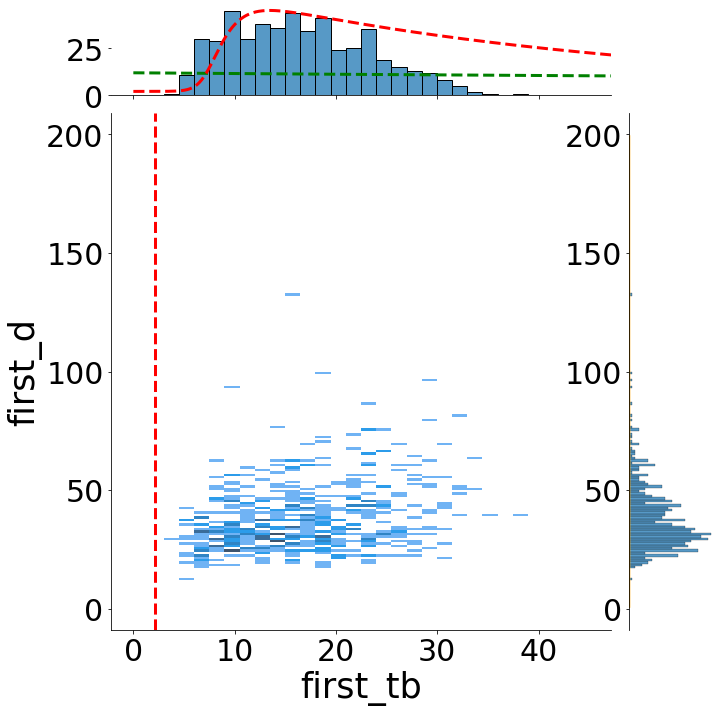

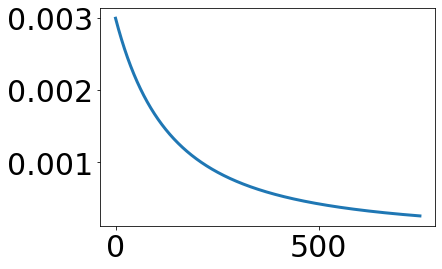

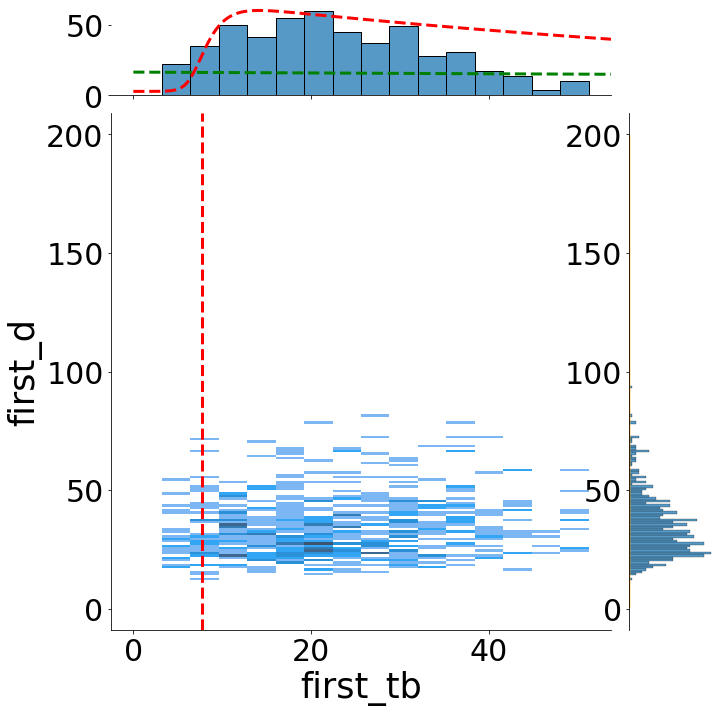

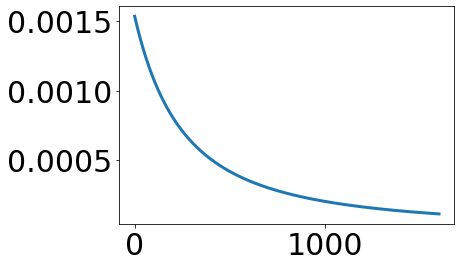

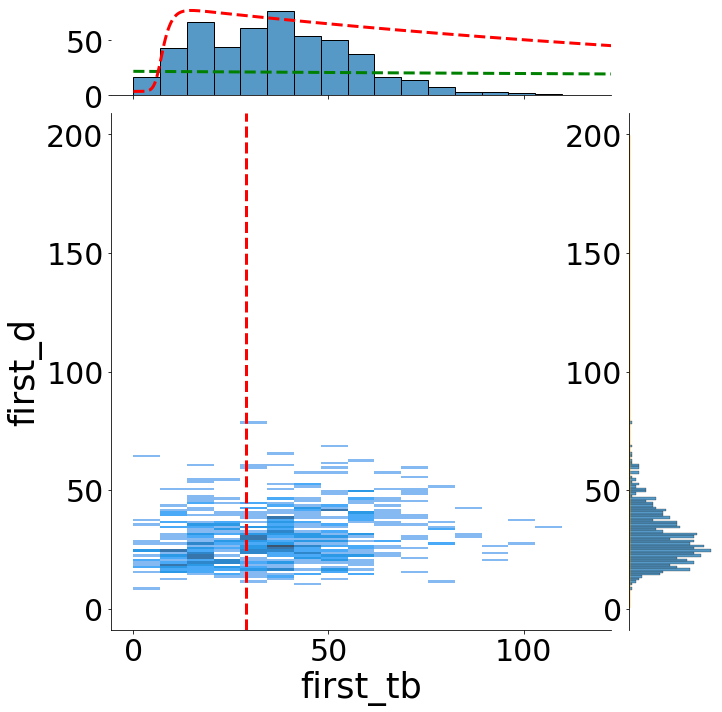

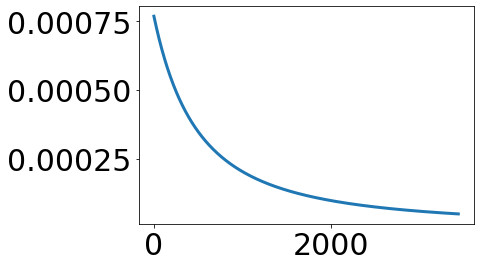

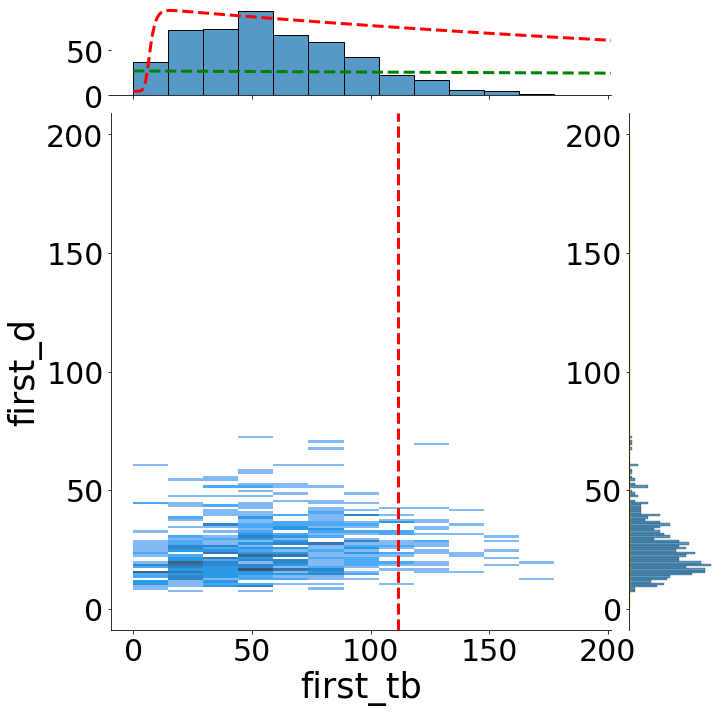

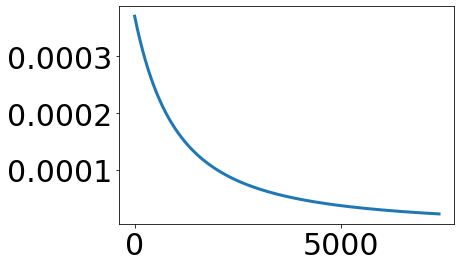

In [ ]:
for kappa in kappa_s[kappa_s>=100]:
    ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),10000)
    x,y,z = odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
    t_peak = ts_det[np.argmax(y)]
    qdf = df.query(f'infection_rate=={R0} and kappa=={kappa} and xi=={xi} and mutation_rate=={mu}')
    J = sns.jointplot(qdf, x='first_tb', y='first_d', kind='hist', bins=(ts_det[ts_det<= qdf['first_tb'].max()][::20],ds), height=10, stat='density')

    tax = J.ax_marg_x.twinx()
    tax.axis('off')
    dbar = 1/p_alpha
    yp = y[np.argmax(y)]
    zp = z[np.argmax(y)]
    total_rate = mu*N*yp* dbar/xi * zp/(1-zp)
    dt = ts_det[1]-ts_det[0]
    ds = np.arange(1,20/p_alpha)

    J.ax_joint.axvline(1/total_rate, color='red', linestyle='--')
    xlim = J.ax_marg_x.get_xlim()
    #l_dt = np.array([lambda_d_t(d,ts_det, mu,N ,yp, zp ,xi) for d in ds])
    p_t=0
    p_ds = []
    for d in ds:
        l_dt = np.array(lambda_d_t(d,ts_det, mu,N ,yp, zp, p_alpha ,xi))
        p_dt = mu*N*yp*zp/(1-zp)*(1-np.exp(-d/xi))*(1-p_alpha)**(d-1) * np.exp(-l_dt)
        p_t += p_dt
        p_ds.append(np.sum(p_dt*dt))
    tax.plot(ts_det,p_t/np.sum(p_t*dt),color='green',linestyle='--')
    
    tax.plot(ts_det,y,color='red',linestyle='--')
    # tax.plot(ts_det,np.exp(-total_rate*ts_det),color='blue',linestyle='--')
    tax.set_xlim(xlim)

    taxy = J.ax_marg_y.twinx()
    taxy.axis('off')
    J.ax_marg_y.plot(p_ds/np.sum(p_ds),ds,color='orange')

    plt.figure()
    p_t_norm = p_t/np.sum(p_t*dt)
    plt.plot(ts_det, p_t_norm*np.exp(-np.cumsum(dt*p_t_norm)))
    # plt.plot(ts_det, y/np.sum(y*dt))

In [ ]:
lambda_d_t = lambda d,t, mu,N ,yp, zp, p_alpha ,xi:   mu* N* yp * zp/(1-zp)*(1-p_alpha)**d*(1- np.exp(-d/xi)/(1+1/(p_alpha*xi)))*(
     t + np.log(N*yp)/((1-np.exp(-d/xi))*zp/(1-zp)))


lambda_s_d_t = lambda d,t, mu,N ,yp, zp, p_alpha ,xi:   mu* N* yp * zp/(1-zp)*(1-p_alpha)**d*(1- np.exp(-d/xi)/(1+1/(p_alpha*xi)))*(
     t + np.log(N*yp*(1-np.exp(-d/xi))*zp/(1-zp))/((1-np.exp(-d/xi))*zp/(1-zp)))

<AxesSubplot:xlabel='first_d', ylabel='Density'>

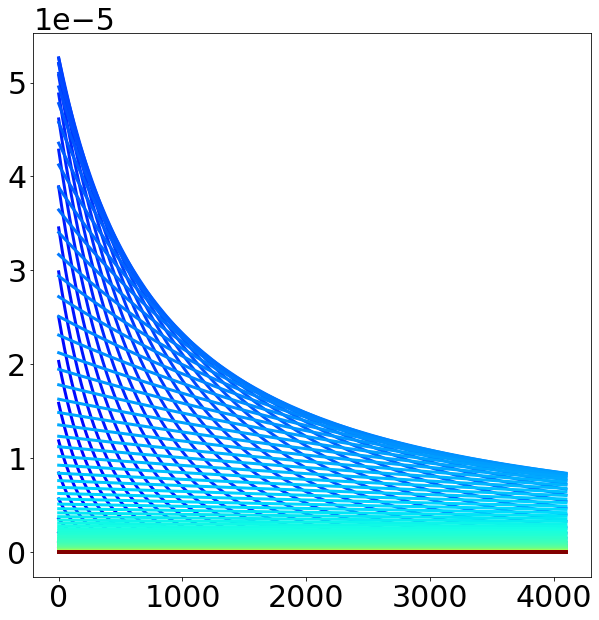

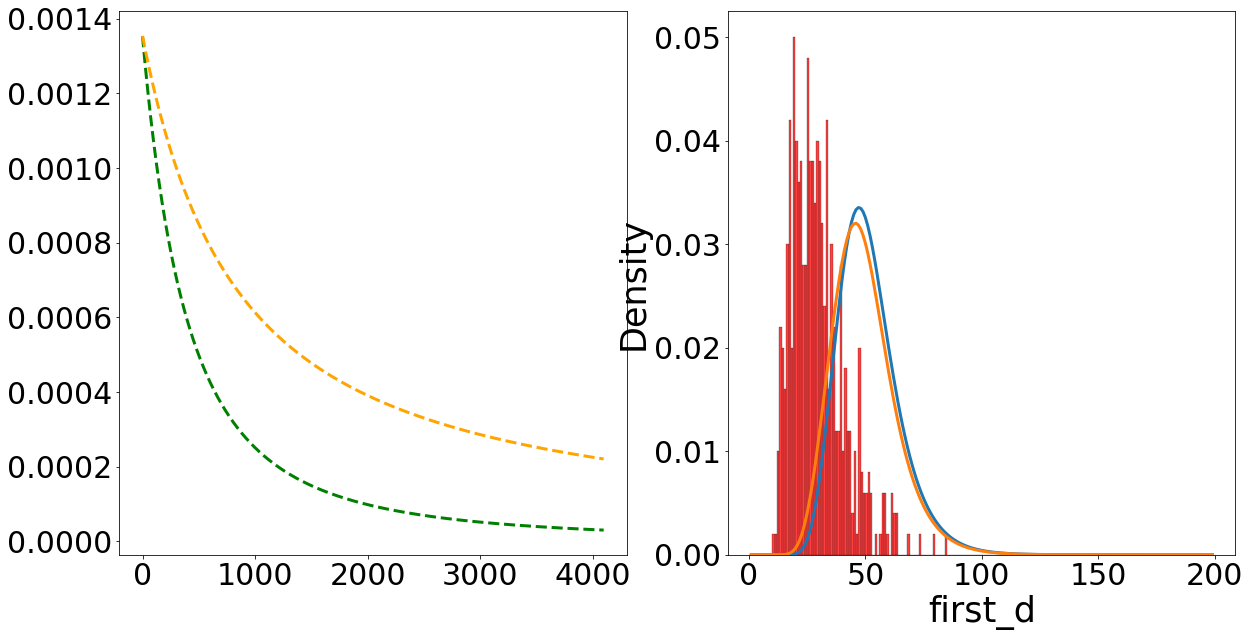

In [ ]:
ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),10000)
x,y,z = odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
t_peak = ts_det[np.argmax(y)]
qdf = df.query(f'infection_rate=={R0} and kappa=={kappa} and xi=={xi} and mutation_rate=={mu}')
# J = sns.jointplot(qdf, x='first_tb', y='first_d', kind='hist', bins=(ts_det[ts_det<= qdf['first_tb'].max()][::20],ds), height=10, stat='density')

tax = J.ax_marg_x.twinx()
tax.axis('off')
dbar = 1/p_alpha
yp = y[np.argmax(y)]
zp = z[np.argmax(y)]
total_rate = mu*N*yp* dbar/xi * zp/(1-zp)
dt = ts_det[1]-ts_det[0]
ds = np.arange(1,20/p_alpha)

#l_dt = np.array([lambda_d_t(d,ts_det, mu,N ,yp, zp ,xi) for d in ds])
p_t=0
p_ds = []
fig,ax=  plt.subplots(1,1, figsize=(10,10))
colors_d = funcs.color_dict(ds,plt.cm.jet)
p_t=0
pd = []
psd = []
for d in ds:
    l_dt = np.array(lambda_d_t(d,ts_det, mu,N ,yp, zp, p_alpha ,xi))
    ls_dt = np.array(lambda_s_d_t(d,ts_det, mu,N ,yp, zp, p_alpha ,xi))
    p_dt = mu*N*yp*zp/(1-zp)*(1-np.exp(-d/xi))*(1-p_alpha)**(d-1)*p_alpha * np.exp(-l_dt)
    p_sdt = mu*N*yp*zp/(1-zp)*(1-np.exp(-d/xi))*(1-p_alpha)**(d-1)*p_alpha * np.exp(-ls_dt)
    ax.plot(ts_det,p_dt,color= colors_d[d])
    p_t += p_dt
    pd.append(np.sum(p_dt*dt))
    psd.append(np.sum(p_sdt*dt))
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].plot(ts_det,p_t*np.exp(-np.cumsum(dt*p_t)),color='green',linestyle='--')
ax[0].plot(ts_det,p_t,color='orange',linestyle='--')

ax[1].plot(ds,pd/np.sum(pd))
ax[1].plot(ds,psd/np.sum(psd))
sns.histplot(qdf, x='first_d', bins=ds, ax=ax[1], stat='density', color='red')


10it [00:00, 400.98it/s]


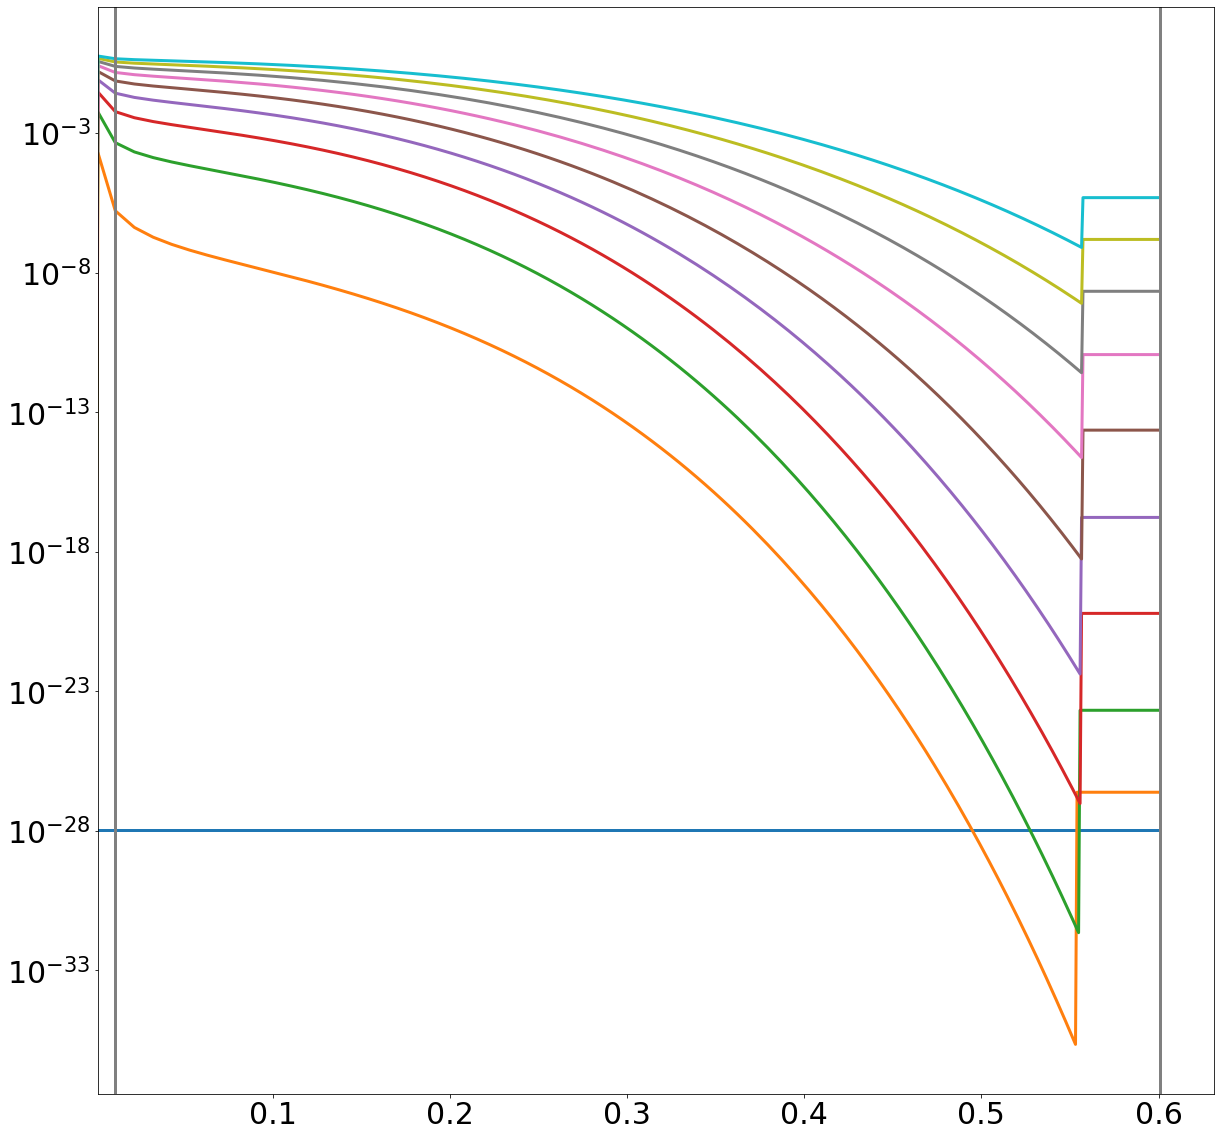

In [ ]:
ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
dt = ts_det[1]-ts_det[0]
x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
z_func = interp1d(ts_det,z)

ds = np.linspace(0,z_df['first_d'].max())
zs = z_func(ts_det)

fig,ax= plt.subplots(1,1, figsize=(20,20))

for i_d, d in tqdm(enumerate(ds[:10])):
    c= np.exp(-d/xi)
    zx_d=  zx_dz[i_d, :]
    
    zxintegral = -zx_d - np.log(1-zx_d)
    integral_c = (1 + xi*p_alpha*(1-c))/(1+xi*p_alpha)*c**(xi*p_alpha)

    zxline, = ax.plot(zs, np.exp(-mu*N*zxintegral* integral_c))#, color='black', alpha=.1)
    # ax.plot(zs, zx_d**2/2 + zx_d**3/3,linestyle='--',color =zxline.get_color())#, color='black', alpha=.1)

ax.axvline(1-1/R0*(1-R0/kappa),color='grey')
ax.axvline(z_func(ts_det[np.argmax(y)]),color='grey')
ax.set_xlim(left=.001)
ax.set_yscale('log')
# ax.set_ylim(bottom=.001)
# ax.set_xscale('log')

In [ ]:
#zx approx: 1 + (-1 + z)*(-1 + (N*(-1 + R0)*z*(-1 + c(d)))/((-1 + z)*\[Kappa]))**(1/(\[Kappa] - \[Kappa]*c(d)))
zx_approx= lambda z,c, R0, kappa, N: 1 + (-1 + z)*(-1 + N*(-1 + R0)*z*(-1 + c)/((-1 + z)*kappa))**(1/(kappa - kappa*c))

#zx approx 2:        ((-1 + R0)*(1 + ProductLog(-((E**((-1 + c)*(1 + R0*(-1 + z)))*(-1 + R0*(-1 + z))**((-1 + c)*(-1 + R0))*(-1 + ((-1 + c)*Npop*(1 + R0*(-1 + z))*z)/\[Kappa])**(R0**2/\[Kappa]))**(1/((-1 + c)*(-1 + R0)))/(-1 + R0)))))/R0
zx_approx2 = lambda z,c, R0, kappa, N: 1+ np.real(sps.lambertw(-np.exp(-(1-z))*(1-z)*np.power((1-c)*z/(1-z)*N/kappa*(R0*(1-z)-1), - (1-1/R0*(1-kappa/R0))/(1-c)),k=-1))

100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


(0.001, 10.0)

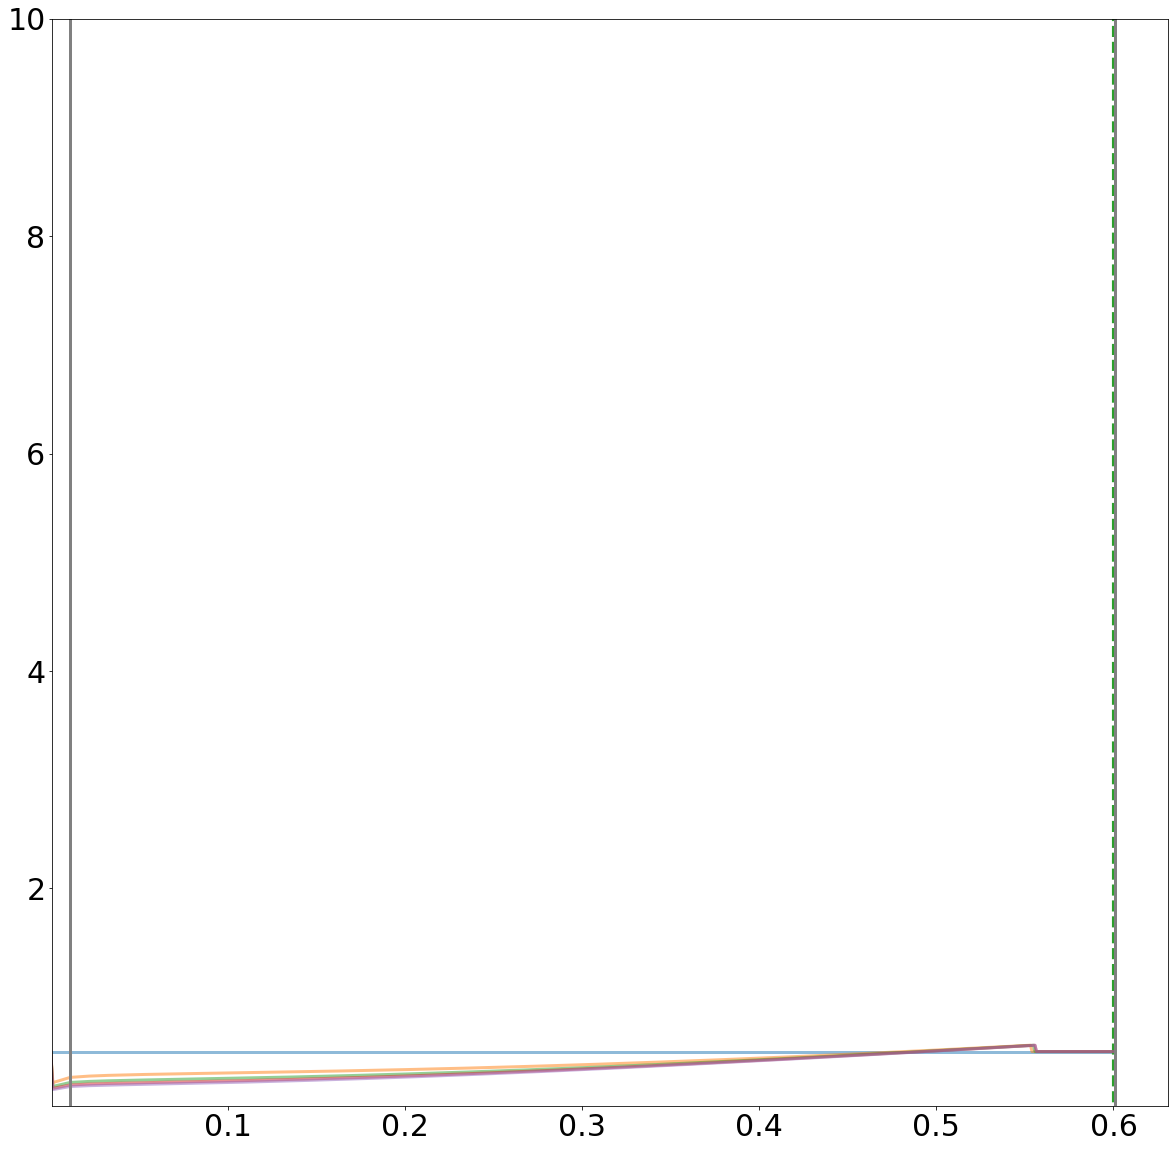

In [ ]:
ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
dt = ts_det[1]-ts_det[0]
x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
z_func = interp1d(ts_det,z)

ds = np.linspace(0,z_df['first_d'].max())
zs = z_func(ts_det)

fig,ax= plt.subplots(1,1, figsize=(20,20))

for d in tqdm(ds[:5]):
    c=  np.exp(-d/xi)
    zx_d=  np.array([get_z_intersection(z_func, d, tb, R0, N, xi, kappa) for tb in ts_det])
    zxline, = ax.plot(zs, zx_d,alpha=.5)#, color='black', alpha=.1)
    ax.plot(zs, zx_approx2(zs,c, R0, kappa, N),linestyle='--',color =zxline.get_color())#, color='black', alpha=.1)

    # ax.plot(zs, zx_d**2/2 + zx_d**3/3,linestyle='--',color =zxline.get_color())#, color='black', alpha=.1)

ax.axvline(1-1/R0*(1-R0/kappa),color='grey')
ax.axvline(z_func(ts_det[np.argmax(y)]),color='grey')
ax.set_xlim(left=.001)
# ax.set_yscale('log')
ax.set_ylim(bottom=.001,top=10)

In [ ]:
zx_approx2(zs,c, R0, kappa, N)

array([          inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -

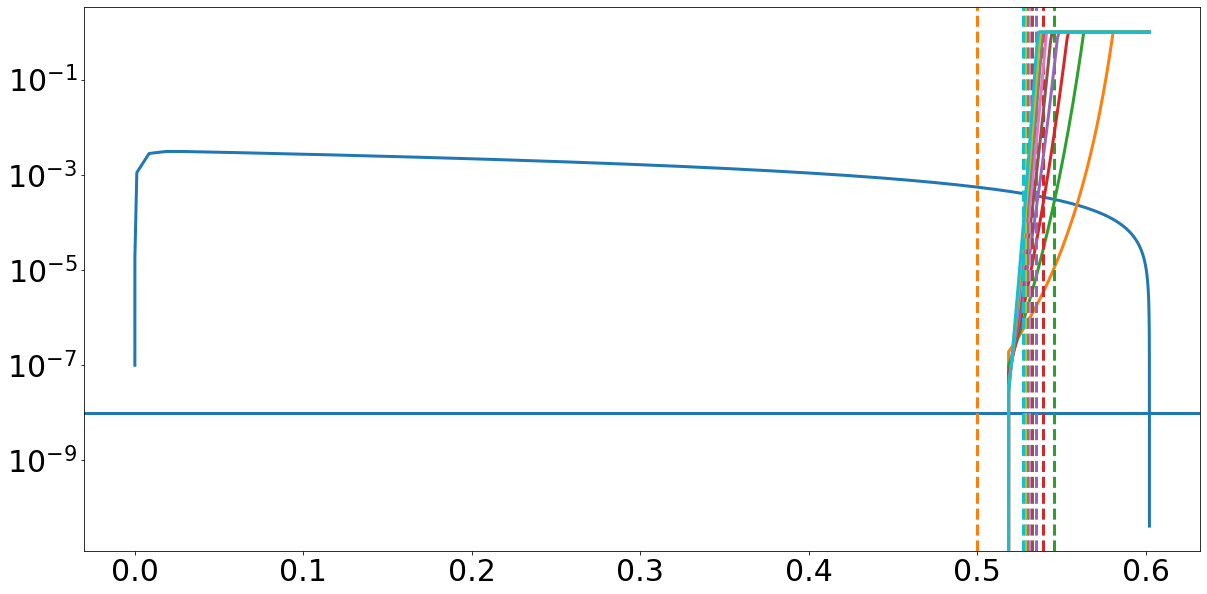

In [ ]:
fig,ax =plt.subplots(figsize=(20,10))
ax.plot(zs,y)
ax.set_yscale('log')
ax.axhline(1/N)

tb = 2x*kappa/R0
for d in range(1,10):
    sd = (1-np.exp(-d/xi))*zs/(1-zs)
    ind_tb = np.argmin(np.abs(ts_det-tb))

    dt=  ts_det[1]-ts_det[0]

    mut_traj = np.exp(dt*(np.cumsum(sd) ))* (ts_det>=tb)

    zint = get_z_intersection(z_func, d, tb, R0, N, xi, kappa)


    c, = ax.plot(zs,np.minimum(mut_traj/(mut_traj[ind_tb+1]*sd[ind_tb]*N),1))
    ax.axvline(zint, color=c.get_color(), linestyle='--')


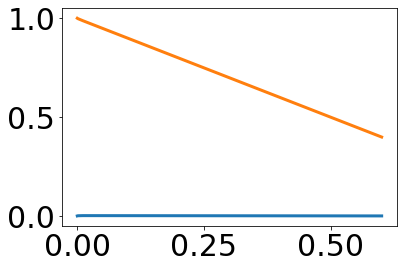

In [ ]:

# plt.yscale('logit')

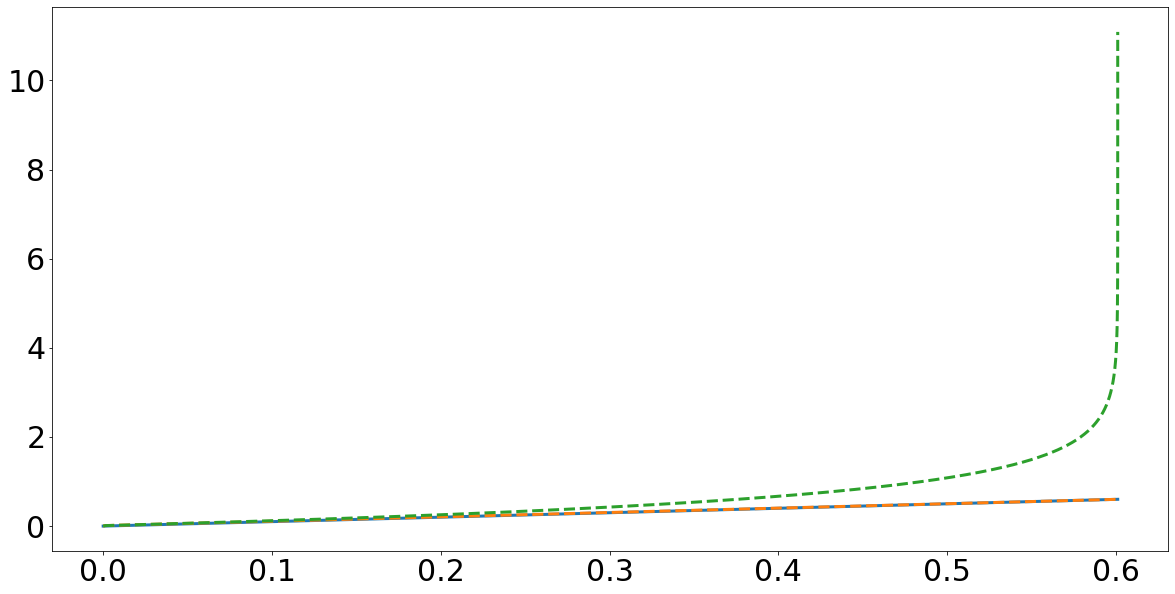

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(z,z)

plt.plot(z, z[-1]*(1-np.exp(-ts_det/kappa*R0)),linestyle='--')
plt.plot(z, z[-1]*ts_det/kappa*R0,linestyle='--')

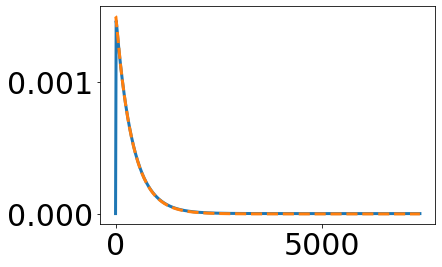

In [ ]:
plt.plot(ts_det,y)
plt.plot(ts_det, (R0*(1-z)-1)/kappa,linestyle='--')

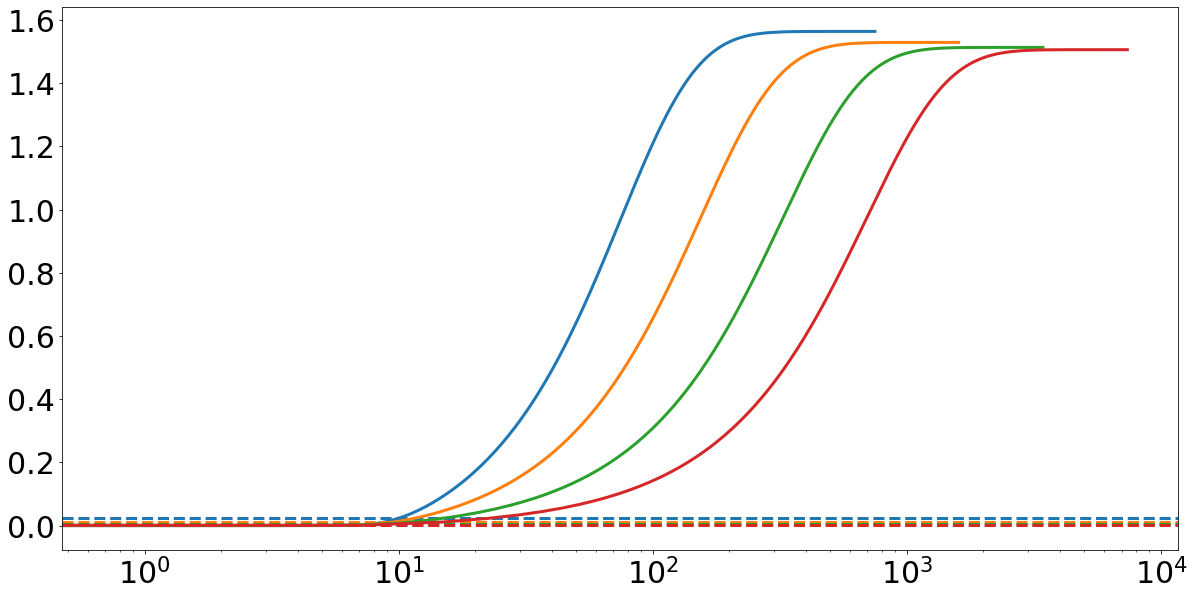

In [ ]:
fig,ax =plt.subplots(figsize=(20,10))

for kappa in kappa_s[kappa_s>=100]:
    ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
    dt = ts_det[1]-ts_det[0]
    x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T

    cc,=plt.plot(ts_det, z/(1-z), label=kappa)
    plt.axhline(R0/kappa,color=cc.get_color(),linestyle='--')
ax.set_xscale('log')